In [127]:
import pandas as pd
import numpy as np

from scipy.signal import lfilter

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error as mse


from scipy.optimize import minimize


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import pymc3 as pm
import seaborn as sns
from matplotlib import animation
import theano.tensor as tt


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import arviz as az
az.rcParams['plot.max_subplots'] = 60

from prophet import Prophet

In [128]:
raw_data_perf = pd.read_excel('MMM.xlsx', sheet_name='Data', header=1)

raw_data_perf

,year,week,Argos Sales Volume,Tesco Sales Volume,Argos Sales Value,Tesco Sales Value,Argos Price,Tesco Price,Argos Distribution,Tesco Distribution,Average UK Temperature,Average UK Rainfall,TVRs,Cinema Admissions,YouTube Impressions
0,2015,2015-12-28,11795,10813,45056.90,40224.36,3.82,3.72,0.65,0.82,6.703522,8.932500,0,0.000000e+00,0
1,2016,2016-01-04,9919,10482,38088.96,39202.68,3.84,3.74,0.65,0.82,6.492818,5.324286,0,0.000000e+00,0
2,2016,2016-01-11,9276,10739,41927.52,40056.47,4.52,3.73,0.65,0.82,6.002794,6.311429,0,0.000000e+00,0
3,2016,2016-01-18,9585,13063,46678.95,45851.13,4.87,3.51,0.65,0.82,5.384591,4.302857,0,0.000000e+00,0
4,2016,2016-01-25,8378,15554,41135.98,50550.50,4.91,3.25,0.65,0.82,5.000951,6.515714,0,0.000000e+00,0
5,2016,2016-02-01,9726,14929,47365.62,48519.25,4.87,3.25,0.77,0.85,6.398659,7.344286,0,0.000000e+00,0
6,2016,2016-02-08,9543,12961,46092.69,45752.33,4.83,3.53,0.77,0.85,5.375651,6.501429,0,0.000000e+00,0
7,2016,2016-02-15,9223,12127,41780.19,53722.61,4.53,4.43,0.77,0.85,7.601557,1.941429,0,0.000000e+00,0
8,2016,2016-02-22,10321,13256,38394.12,47986.72,3.72,3.62,0.77,0.85,6.585295,3.424286,0,0.000000e+00,0
9,2016,2016-02-29,10533,12547,39498.75,45796.55,3.75,3.65,0.77,0.83,8.014458,2.584286,0,0.000000e+00,0


In [129]:
raw_data_perf['week'] = pd.to_datetime(raw_data_perf['week'])

In [130]:
raw_data_perf.dtypes

year                               int64
week                      datetime64[ns]
Argos Sales Volume                 int64
Tesco Sales Volume                 int64
Argos Sales Value                float64
Tesco Sales Value                float64
Argos Price                      float64
Tesco Price                      float64
Argos Distribution               float64
Tesco Distribution               float64
Average UK Temperature           float64
Average UK Rainfall              float64
TVRs                               int64
Cinema Admissions                float64
YouTube Impressions                int64
dtype: object

In [131]:
raw_data_perf['Revenue'] = raw_data_perf['Argos Sales Value'] + raw_data_perf['Tesco Sales Value']
raw_data_perf['TV_Cost'] = raw_data_perf['TVRs']*2000
raw_data_perf['Youtube_Cost'] = raw_data_perf['YouTube Impressions']/1000*1.5
raw_data_perf['Cinema Cost'] = raw_data_perf['Cinema Admissions'] * 0.08

raw_data_perf.head()

,year,week,Argos Sales Volume,Tesco Sales Volume,Argos Sales Value,Tesco Sales Value,Argos Price,Tesco Price,Argos Distribution,Tesco Distribution,Average UK Temperature,Average UK Rainfall,TVRs,Cinema Admissions,YouTube Impressions,Revenue,TV_Cost,Youtube_Cost,Cinema Cost
0,2015,2015-12-28,11795,10813,45056.90,40224.36,3.82,3.72,0.65,0.82,6.703522,8.932500,0,0.0,0,85281.26,0,0.0,0.0
1,2016,2016-01-04,9919,10482,38088.96,39202.68,3.84,3.74,0.65,0.82,6.492818,5.324286,0,0.0,0,77291.64,0,0.0,0.0
2,2016,2016-01-11,9276,10739,41927.52,40056.47,4.52,3.73,0.65,0.82,6.002794,6.311429,0,0.0,0,81983.99,0,0.0,0.0
3,2016,2016-01-18,9585,13063,46678.95,45851.13,4.87,3.51,0.65,0.82,5.384591,4.302857,0,0.0,0,92530.08,0,0.0,0.0
4,2016,2016-01-25,8378,15554,41135.98,50550.50,4.91,3.25,0.65,0.82,5.000951,6.515714,0,0.0,0,91686.48,0,0.0,0.0


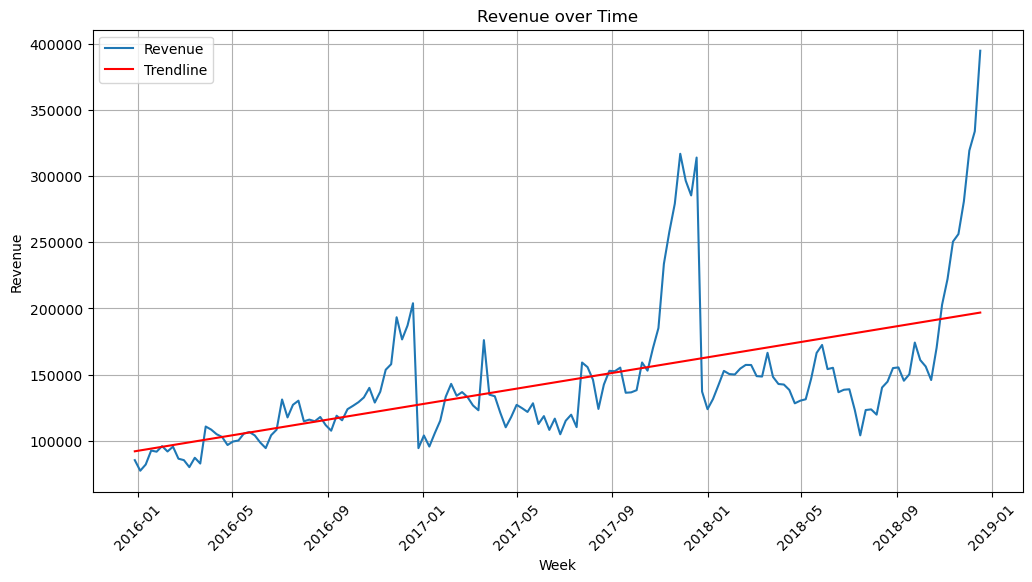

In [132]:

# Plotting the target column against the week column
plt.figure(figsize=(12, 6))
plt.plot(raw_data_perf['week'], raw_data_perf['Revenue'], label='Revenue')
plt.title('Revenue over Time')
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid(True)

# Fit and plot the trendline
x = np.arange(len(raw_data_perf['week']))
coefficients = np.polyfit(x, raw_data_perf['Revenue'], deg=1)
trendline = np.poly1d(coefficients)
plt.plot(raw_data_perf['week'], trendline(x), color='red', label='Trendline')

plt.legend()
plt.show()


In [133]:
m = Prophet(mcmc_samples=300, yearly_seasonality=True)
m.add_country_holidays(country_name='UK')
prophet_data = raw_data_perf.rename(columns = {'Revenue': 'y', 'week': 'ds'})
m.fit(prophet_data[['ds', 'y',]])


18:25:40 - cmdstanpy - INFO - CmdStan installation /Users/kat/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
18:25:40 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
18:25:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                         | 00:00 Status
chain 2 |                                                         | 00:00 Status

chain 3 |                                                         | 00:00 Status


chain 4 |                                                         | 00:00 Status


chain 1 |██████████▍               | 00:01 Iteration:   1 / 300 [  0%]  (Warmup)

chain 3 |██████████▍               | 00:01 Iteration:   1 / 300 [  0%]  (Warmup)
chain 2 |██████████▍               | 00:01 Iteration:   1 / 300 [  0%]  (Warmup)

chain 1 |███████████████▌          | 00:02 Iteration: 100 / 300 [ 33%]  (Warmup)
chain 2 |██████████


18:25:45 - cmdstanpy - INFO - CmdStan done processing.
18:25:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
18:25:45 - cmdstanpy - WARNING - Some chains may ha

## Extract trend and seasonality Predict Future

In [134]:
from datetime import timedelta

preds = m.predict(
    pd.DataFrame({
        "ds": prophet_data['ds'].tolist() +[prophet_data['ds'].tolist()[-1]+timedelta(days=x*7) for x in range(1, 22)]
                 }
    ))

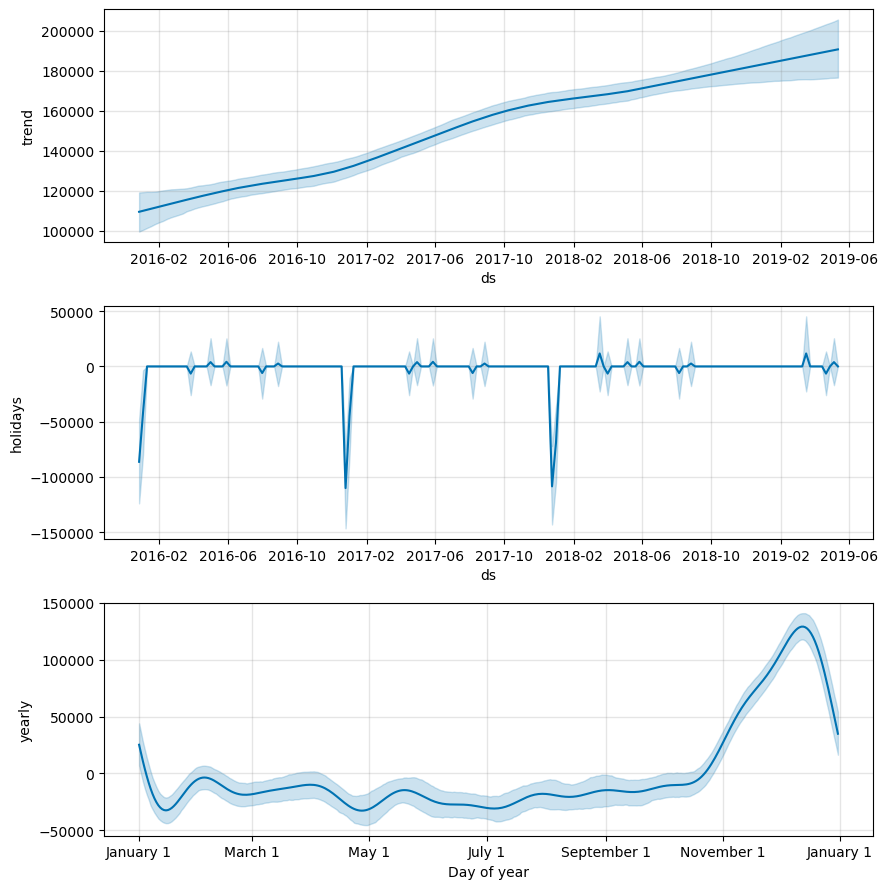

In [135]:
fig = m.plot_components(preds
)

In [136]:
preds = m.predict(prophet_data[['ds']])

In [137]:
preds.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Battle of the Boyne [Northern Ireland],Battle of the Boyne [Northern Ireland]_lower,Battle of the Boyne [Northern Ireland]_upper,Boxing Day,Boxing Day_lower,Boxing Day_upper,Boxing Day (Observed),Boxing Day (Observed)_lower,Boxing Day (Observed)_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,Christmas Day (Observed)_upper,Easter Monday [England/Wales/Northern Ireland],Easter Monday [England/Wales/Northern Ireland]_lower,Easter Monday [England/Wales/Northern Ireland]_upper,Good Friday,Good Friday_lower,Good Friday_upper,Late Summer Bank Holiday [England/Wales/Northern Ireland],Late Summer Bank Holiday [England/Wales/Northern Ireland]_lower,Late Summer Bank Holiday [England/Wales/Northern Ireland]_upper,May Day,May Day_lower,May Day_upper,New Year Holiday [Scotland],New Year Holiday [Scotland]_lower,New Year Holiday [Scotland]_upper,New Year Holiday [Scotland] (Observed),New Year Holiday [Scotland] (Observed)_lower,New Year Holiday [Scotland] (Observed)_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,New Year's Day (Observed),New Year's Day (Observed)_lower,New Year's Day (Observed)_upper,Spring Bank Holiday,Spring Bank Holiday_lower,Spring Bank Holiday_upper,St. Andrew's Day [Scotland],St. Andrew's Day [Scotland]_lower,St. Andrew's Day [Scotland]_upper,St. Patrick's Day [Northern Ireland],St. Patrick's Day [Northern Ireland]_lower,St. Patrick's Day [Northern Ireland]_upper,St. Patrick's Day [Northern Ireland] (Observed),St. Patrick's Day [Northern Ireland] (Observed)_lower,St. Patrick's Day [Northern Ireland] (Observed)_upper,Summer Bank Holiday [Scotland],Summer Bank Holiday [Scotland]_lower,Summer Bank Holiday [Scotland]_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-12-28,109598.264636,45020.714877,127445.807674,99700.504944,119263.755133,0.0,0.0,0.0,0.0,0.0,0.0,-86372.996289,-124002.501544,-48101.343847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-23688.426572,-54057.858788,7988.640375,-86372.996289,-124002.501544,-48101.343847,62684.569717,43438.247786,81309.522104,0.0,0.0,0.0,85909.838064
1,2016-01-04,110105.015802,33185.658678,119113.177575,100555.456776,119413.693682,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-41675.180705,-79613.087542,-3505.662386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-32791.772910,-67103.696214,26.796841,-41675.180705,-79613.087542,-3505.662386,8883.407796,-8455.552191,25904.844466,0.0,0.0,0.0,77313.242893
2,2016-01-11,110611.766969,51761.526230,116512.095060,101517.693521,119594.549329,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-25977.987180,-37889.662087,-12684.654999,0.000000,0.000000,0.000000,-25977.987180,-37889.662087,-12684.654999,0.0,0.0,0.0,84633.779789
3,2016-01-18,111118.518136,48204.933589,111604.898502,102387.275970,119557.435316,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-31197.360330,-42891.673010,-19313.076827,0.000000,0.000000,0.000000,-31197.360330,-42891.673010,-19313.076827,0.0,0.0,0.0,79921.157805
4,2016-01-25,111625.269302,61859.142188,123719.799475,103435.007210,119670.801192,0.0,0.0,0.0

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


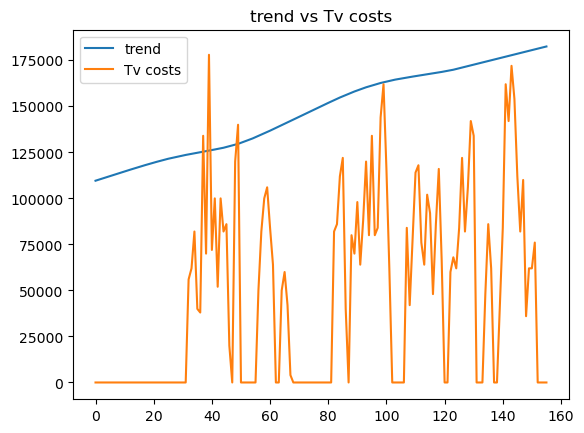

In [138]:
%pylab inline
title("trend vs Tv costs")
plot(preds["trend"], label="trend")
plot(prophet_data["TV_Cost"], label="Tv costs")
legend()

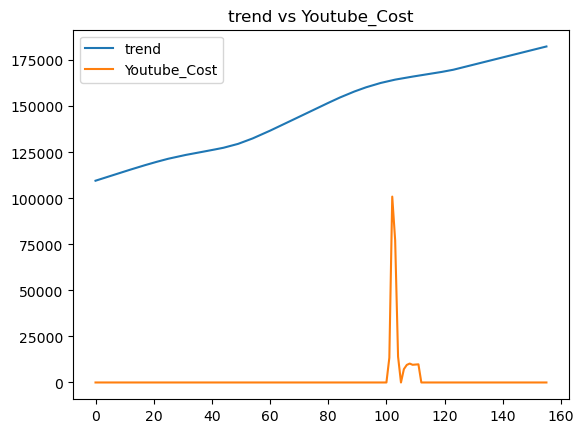

In [139]:
title("trend vs Youtube_Cost")
plot(preds["trend"], label="trend")
plot(prophet_data["Youtube_Cost"]*40, label="Youtube_Cost")
legend()

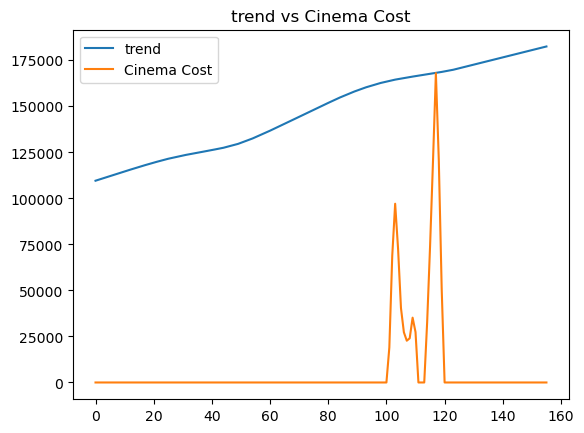

In [140]:
title("trend vs Cinema Cost")
plot(preds["trend"], label="trend")
plot(prophet_data["Cinema Cost"]*2, label="Cinema Cost")
legend()

In [141]:
data = prophet_data
data["trend"] = preds["trend"]
data["season"] = preds["yearly"]

data.head()

,year,ds,Argos Sales Volume,Tesco Sales Volume,Argos Sales Value,Tesco Sales Value,Argos Price,Tesco Price,Argos Distribution,Tesco Distribution,Average UK Temperature,Average UK Rainfall,TVRs,Cinema Admissions,YouTube Impressions,y,TV_Cost,Youtube_Cost,Cinema Cost,trend,season
0,2015,2015-12-28,11795,10813,45056.90,40224.36,3.82,3.72,0.65,0.82,6.703522,8.932500,0,0.0,0,85281.26,0,0.0,0.0,109598.264636,62684.569717
1,2016,2016-01-04,9919,10482,38088.96,39202.68,3.84,3.74,0.65,0.82,6.492818,5.324286,0,0.0,0,77291.64,0,0.0,0.0,110105.015802,8883.407796
2,2016,2016-01-11,9276,10739,41927.52,40056.47,4.52,3.73,0.65,0.82,6.002794,6.311429,0,0.0,0,81983.99,0,0.0,0.0,110611.766969,-25977.987180
3,2016,2016-01-18,9585,13063,46678.95,45851.13,4.87,3.51,0.65,0.82,5.384591,4.302857,0,0.0,0,92530.08,0,0.0,0.0,111118.518136,-31197.360330
4,2016,2016-01-25,8378,15554,41135.98,50550.50,4.91,3.25,0.65,0.82,5.000951,6.515714,0,0.0,0,91686.48,0,0.0,0.0,111625.269302,-17766.668164


## PyMC3

In [142]:
X = data[[ 'Argos Distribution', 'Tesco Distribution',  'trend', 'season', 'TV_Cost', 'Youtube_Cost', 'Cinema Cost']]

y = data['y']

In [143]:
X.head()

,Argos Distribution,Tesco Distribution,trend,season,TV_Cost,Youtube_Cost,Cinema Cost
0,0.65,0.82,109598.264636,62684.569717,0,0.0,0.0
1,0.65,0.82,110105.015802,8883.407796,0,0.0,0.0
2,0.65,0.82,110611.766969,-25977.987180,0,0.0,0.0
3,0.65,0.82,111118.518136,-31197.360330,0,0.0,0.0
4,0.65,0.82,111625.269302,-17766.668164,0,0.0,0.0


In [144]:
media_spend_columns = ['Cinema Cost', 'Youtube_Cost', 'TV_Cost']
control_columns = ['season', 'trend']
#enemy_columns = ['Average UK Temperature']
#negative_columns = ['']
dist_columns = ['Argos Distribution', 'Tesco Distribution']
#price_columns = ['Argos Price', 'Tesco Price']
#negative_columns = ['Average UK Temperature']

In [145]:
X_transformed = X.copy()
X_encoder_dict = {}
for feature in media_spend_columns + control_columns + dist_columns:
    scaler = MinMaxScaler()
    original = X[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    X_transformed[feature] = transformed
    X_encoder_dict[feature] = scaler
    
y_transformed = y.copy()
y_transformed /= 1000


In [146]:
X_transformed.head()

,Argos Distribution,Tesco Distribution,trend,season,TV_Cost,Youtube_Cost,Cinema Cost
0,0.0,0.3,0.000000,0.588979,0.0,0.0,0.0
1,0.0,0.3,0.006950,0.255818,0.0,0.0,0.0
2,0.0,0.3,0.013900,0.039941,0.0,0.0,0.0
3,0.0,0.3,0.020849,0.007620,0.0,0.0,0.0
4,0.0,0.3,0.027799,0.090789,0.0,0.0,0.0


In [147]:
def saturate(x, a):
    return 1 - tt.exp(-a*x)

def carryover(x, strength, delay, length=12):
    w = tt.as_tensor_variable(
        [tt.power(strength, (i-delay) ** 2) for i in range(length)]
    )
    
    x_lags = tt.stack(
        [tt.concatenate([
            tt.zeros(i),
            x[:x.shape[0]-i]
        ]) for i in range(length)]
    )
    
    return tt.dot(w, x_lags) / tt.sum(w)

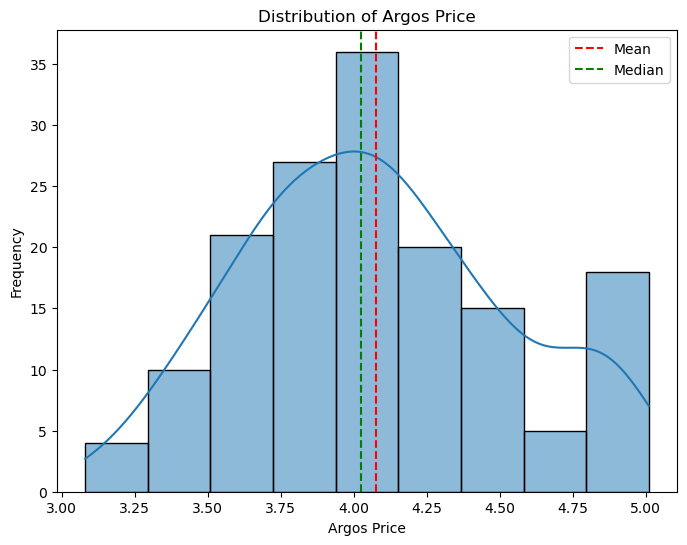

Column: Argos Price
Mean: 4.07
Median: 4.03
Standard Deviation: 0.45
------------------------------


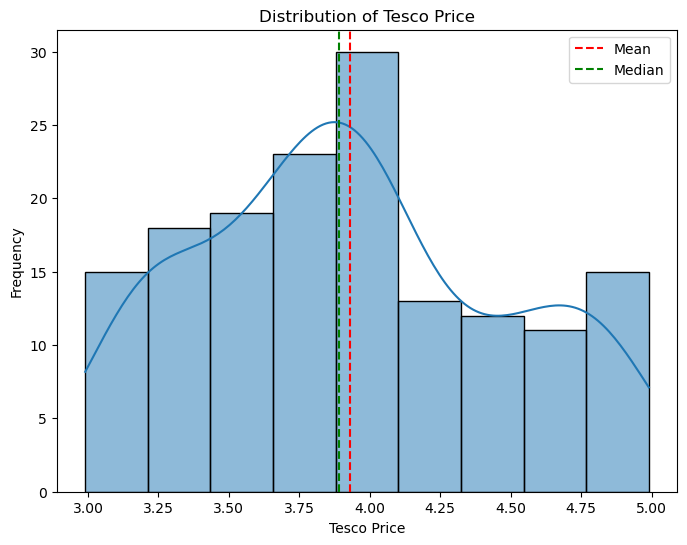

Column: Tesco Price
Mean: 3.93
Median: 3.89
Standard Deviation: 0.54
------------------------------


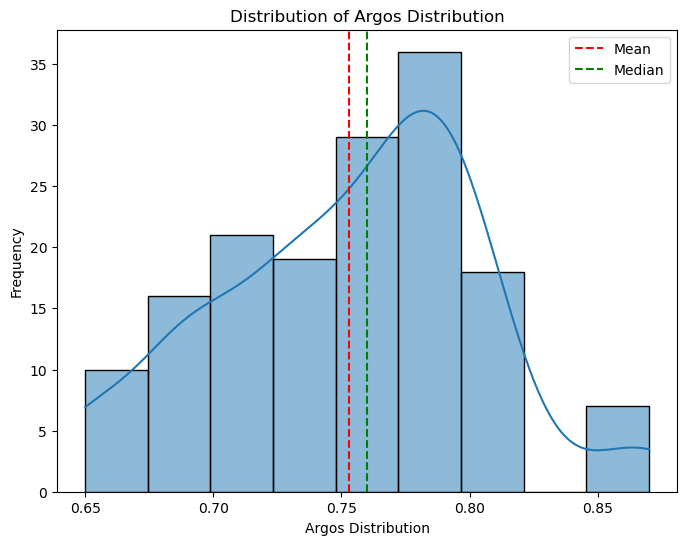

Column: Argos Distribution
Mean: 0.75
Median: 0.76
Standard Deviation: 0.05
------------------------------


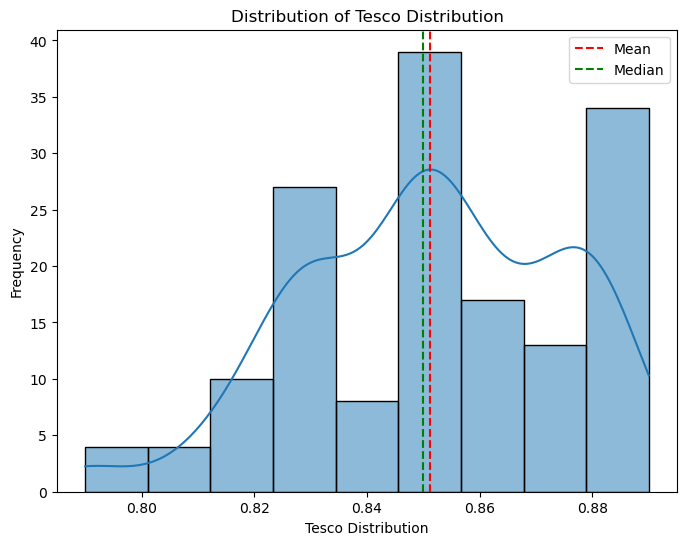

Column: Tesco Distribution
Mean: 0.85
Median: 0.85
Standard Deviation: 0.02
------------------------------


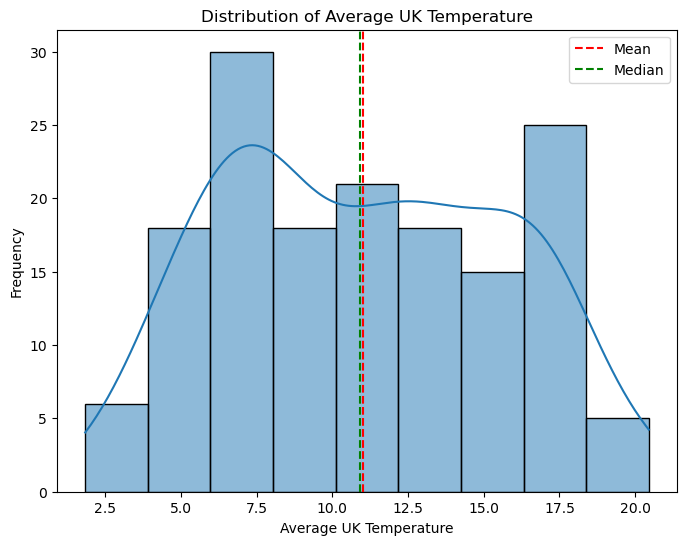

Column: Average UK Temperature
Mean: 11.00
Median: 10.91
Standard Deviation: 4.60
------------------------------


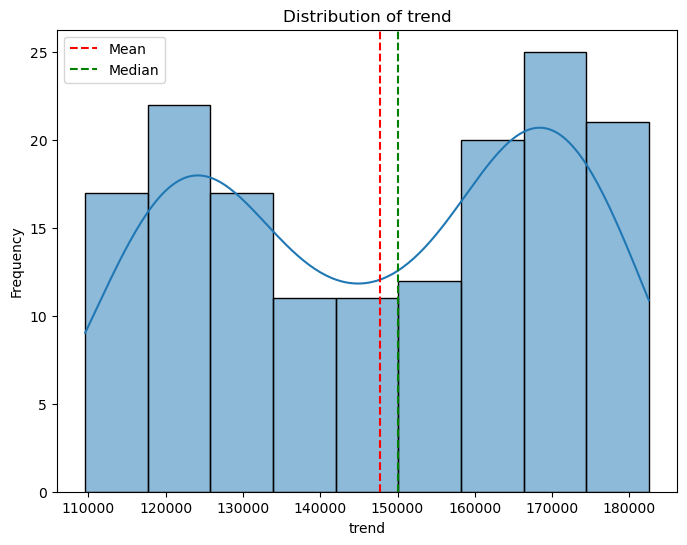

Column: trend
Mean: 147690.86
Median: 150013.42
Standard Deviation: 22644.36
------------------------------


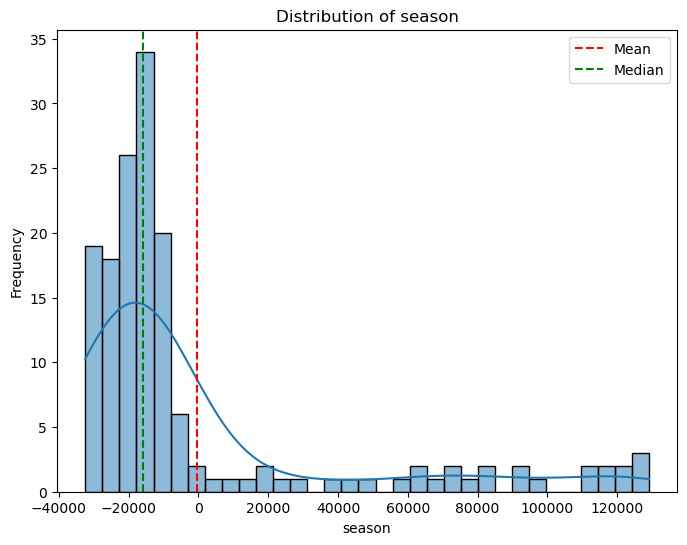

Column: season
Mean: -348.15
Median: -15801.50
Standard Deviation: 41054.32
------------------------------


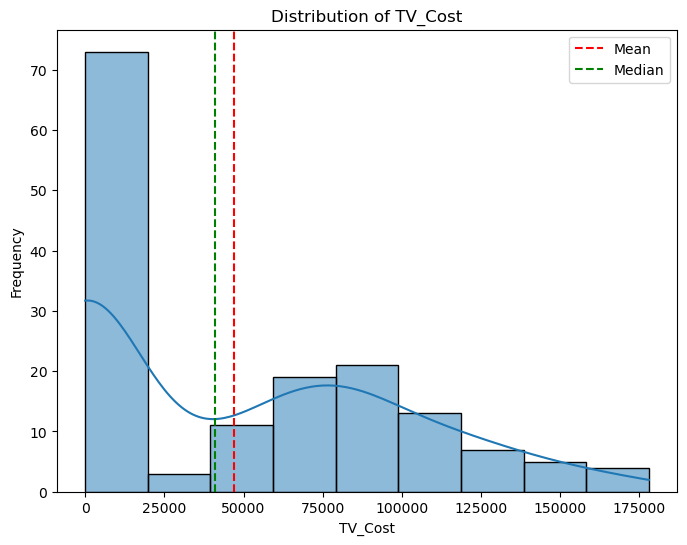

Column: TV_Cost
Mean: 47025.64
Median: 41000.00
Standard Deviation: 50860.71
------------------------------


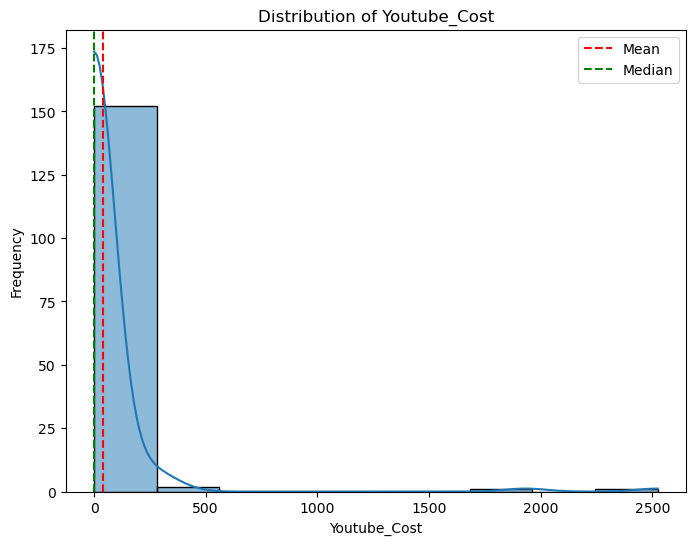

Column: Youtube_Cost
Mean: 41.98
Median: 0.00
Standard Deviation: 259.00
------------------------------


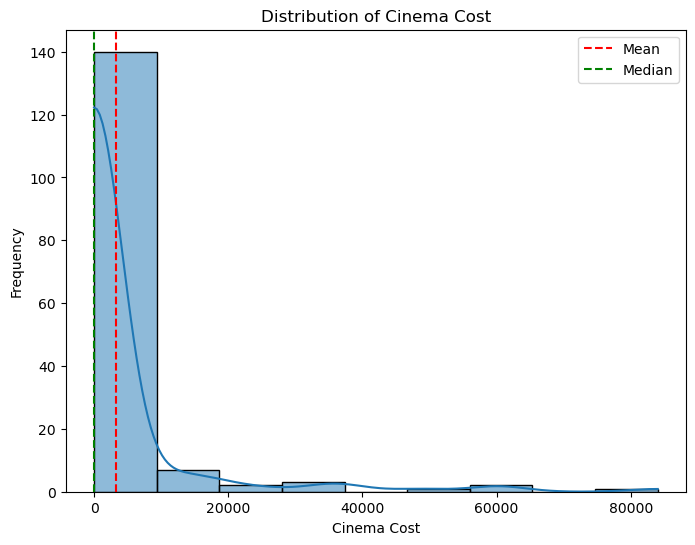

Column: Cinema Cost
Mean: 3207.66
Median: 0.00
Standard Deviation: 11720.35
------------------------------


In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the columns containing the metrics you want to examine
metric_columns = data[['Argos Price', 'Tesco Price', 'Argos Distribution', 'Tesco Distribution', 'Average UK Temperature', 'trend', 'season', 'TV_Cost', 'Youtube_Cost', 'Cinema Cost']]

# Loop through the metric columns
for column in metric_columns:
    # Extract the data for the current column
    data_column = data[column]
    
    # Calculate summary statistics
    mean = data_column.mean()
    median = data_column.median()
    std = data_column.std()
    
    # Plot the distribution
    plt.figure(figsize=(8, 6))
    sns.histplot(data_column, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    
    # Add mean and median lines to the plot
    plt.axvline(mean, color='r', linestyle='--', label='Mean')
    plt.axvline(median, color='g', linestyle='--', label='Median')
    
    plt.legend()
    plt.show()

    # Print the summary statistics
    print(f'Column: {column}')
    print(f'Mean: {mean:.2f}')
    print(f'Median: {median:.2f}')
    print(f'Standard Deviation: {std:.2f}')
    print('-' * 30)


In [149]:
with pm.Model() as mmm:
    channel_contributions = []
    
    for channel in media_spend_columns:
        coef = pm.Gamma(f'coef_{channel}', alpha=5, beta=1)
        sat = pm.Gamma(f'sat_{channel}', alpha=3, beta=0.5)
        car = pm.Beta(f'car_{channel}', alpha=5, beta=5)
        delay = pm.HalfNormal(f'delay_{channel}', sd=4)
        
        channel_data = X_transformed[channel].values
        channel_contribution = pm.Deterministic(
            f'contribution_{channel}',
            coef * saturate(
                carryover(
                    channel_data,
                    car,
                    delay
                ),
                sat
            )
        ) 
        channel_contributions.append(channel_contribution)
        
        
    for channel in dist_columns:
        coef = pm.Gamma(f'coef_{channel}', alpha=5, beta=1)
        sat = pm.Gamma(f'sat_{channel}', alpha=3, beta=0.5)
        car = pm.Beta(f'car_{channel}', alpha=5, beta=5)
        delay = pm.HalfNormal(f'delay_{channel}', sd=4)
        
        channel_data = X_transformed[channel].values
        channel_contribution = pm.Deterministic(
            f'contribution_{channel}',
           coef * saturate(
                carryover(
                    channel_data,
                    car,
                    delay
                ),
                sat
            )
        ) 
        channel_contributions.append(channel_contribution)
        
    
        
        
        
        
    for channel in ['season', 'trend']:
        coef = pm.Gamma(f'coef_{channel}', alpha=3, beta=1)
        channel_data = X_transformed[channel].values
        channel_contribution = pm.Deterministic(f'contribution_{channel}', coef * channel_data)
        
        channel_contributions.append(channel_contribution)
        
        
        
        
    base = pm.Gamma(f'base', alpha=1, beta=0.25)
    noise = pm.HalfNormal('noise', sd=0.2)
    
    sales = pm.Normal(
        'sales',
        mu=sum(channel_contributions) + base,
        sigma=noise,
        observed=y_transformed
    )
    
    #step = pm.NUTS()
    
    

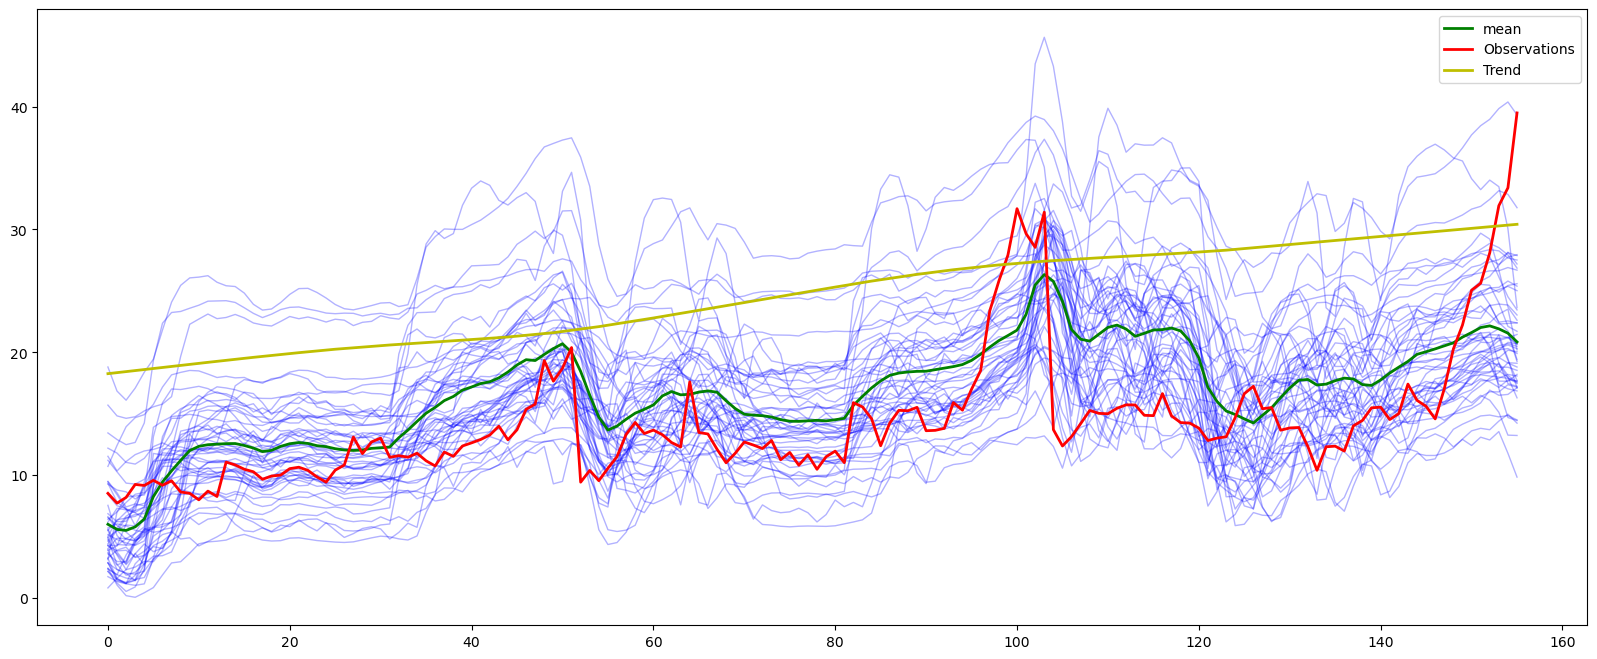

In [150]:
import pymc3 as pm

with mmm:
    plt.figure(figsize=(20, 8))
    ppc = pm.sample_prior_predictive(50)
    for s in ppc['sales']:
        #y_pred, noise_pred = draw_pred(ppc, i)
        plt.plot(s, linewidth=1, c='b', alpha=.3)
    plt.plot(ppc["sales"].mean(axis=0), linewidth=2, c='g', label='mean')
    plt.plot(y/10000, linewidth=2, c='r', label='Observations')
    plt.plot(X["trend"]/6000, linewidth=2, c='y', label='Trend')

    #plt.fill_between(np.arange(len(y)), y_pred - noise, y_pred + noise, alpha=0.33)
    plt.legend()

In [151]:


def draw_pred(trace_p, num):
    channel_contributions = []
    
    for channel in media_spend_columns:
        coef = trace_p[f'coef_{channel}'].values.reshape(4000, 1).mean()
        sat = trace_p[f'sat_{channel}'].values.reshape(4000, 1).mean()
        car = trace_p[f'car_{channel}'].values.reshape(4000, 1).mean()
        delay = trace_p[f'delay_{channel}'].values.reshape(4000, 1).mean()
        
        channel_data = X_transformed[channel].values
        channel_contribution = coef * saturate(
                carryover(
                    channel_data,
                    car,
                    delay
                ),
                saturate
            ).eval()
        channel_contributions.append(channel_contribution)
        
        
    for channel in dist_columns:
        coef = trace_p[f'coef_{channel}'].values.reshape(4000, 1).mean()
        sat = trace_p[f'sat_{channel}'].values.reshape(4000, 1).mean()
        car = trace_p[f'car_{channel}'].values.reshape(4000, 1).mean()
        delay = trace_p[f'delay_{channel}'].values.reshape(4000, 1).mean()
        
        channel_data = X_transformed[channel].values
        channel_contribution =  coef * saturate(
                carryover(
                    channel_data,
                    car,
                    delay
                ),
                sat
            ).eval()
        channel_contributions.append(channel_contribution)
        
        
        
    #for channel in ['cbr', 'mrtg_rate_all']:
     #   coef = trace_p[f'coef_{channel}'].values.reshape(4000, 1).mean()
      #  #sat = trace_p[f'sat_{channel}'].values.reshape(4000, 1).mean()
       # channel_data = X_transformed[channel].values
       # channel_contribution = coef * channel_data#saturate(channel_data, sat).eval()
        
       # channel_contributions.append(channel_contribution)
        
        
    for channel in ['season', 'trend']:
        coef = trace_p[f'coef_{channel}'].values.reshape(4000, 1).mean()
        channel_data = X_transformed[channel].values
        channel_contribution =coef * channel_data
        
        channel_contributions.append(channel_contribution)
        
        
    base = trace_p['base'].values.reshape(4000, 1).mean()
    noise = trace_p['noise'].values.reshape(4000, 1).mean()
    
    return np.sum(channel_contributions, axis=0) + base, noise

In [152]:
mmm

In [153]:
with mmm:
    trace = pm.sample(tune=1500,return_inferencedata=True, target_accept=0.98, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [noise, base, coef_trend, coef_season, delay_Tesco Distribution, car_Tesco Distribution, sat_Tesco Distribution, coef_Tesco Distribution, delay_Argos Distribution, car_Argos Distribution, sat_Argos Distribution, coef_Argos Distribution, delay_TV_Cost, car_TV_Cost, sat_TV_Cost, coef_TV_Cost, delay_Youtube_Cost, car_Youtube_Cost, sat_Youtube_Cost, coef_Youtube_Cost, delay_Cinema Cost, car_Cinema Cost, sat_Cinema Cost, coef_Cinema Cost]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 488 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [154]:
# with mmm:
#     pm.traceplot(trace)

<AxesSubplot:xlabel='sales / sales'>

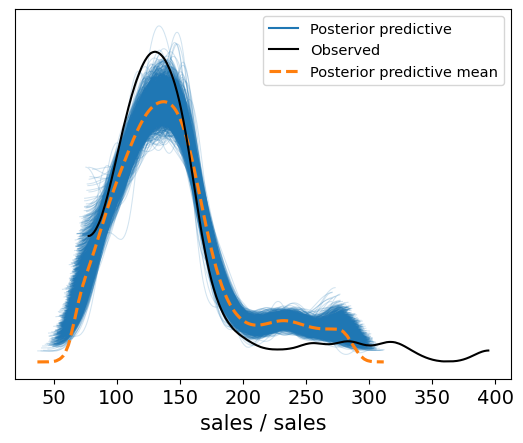

In [155]:
with mmm:
    posterior = pm.sample_posterior_predictive(trace, var_names=["sales"])
az.plot_ppc(az.from_pymc3(posterior_predictive=posterior, model=mmm), var_names = ["sales"])

array([[<AxesSubplot:title={'center':'coef_Cinema Cost'}>,
        <AxesSubplot:title={'center':'sat_Cinema Cost'}>,
        <AxesSubplot:title={'center':'car_Cinema Cost'}>,
        <AxesSubplot:title={'center':'delay_Cinema Cost'}>],
       [<AxesSubplot:title={'center':'coef_Youtube_Cost'}>,
        <AxesSubplot:title={'center':'sat_Youtube_Cost'}>,
        <AxesSubplot:title={'center':'car_Youtube_Cost'}>,
        <AxesSubplot:title={'center':'delay_Youtube_Cost'}>],
       [<AxesSubplot:title={'center':'coef_TV_Cost'}>,
        <AxesSubplot:title={'center':'sat_TV_Cost'}>,
        <AxesSubplot:title={'center':'car_TV_Cost'}>,
        <AxesSubplot:title={'center':'delay_TV_Cost'}>],
       [<AxesSubplot:title={'center':'coef_Argos Distribution'}>,
        <AxesSubplot:title={'center':'sat_Argos Distribution'}>,
        <AxesSubplot:title={'center':'car_Argos Distribution'}>,
        <AxesSubplot:title={'center':'delay_Argos Distribution'}>],
       [<AxesSubplot:title={'center':'co

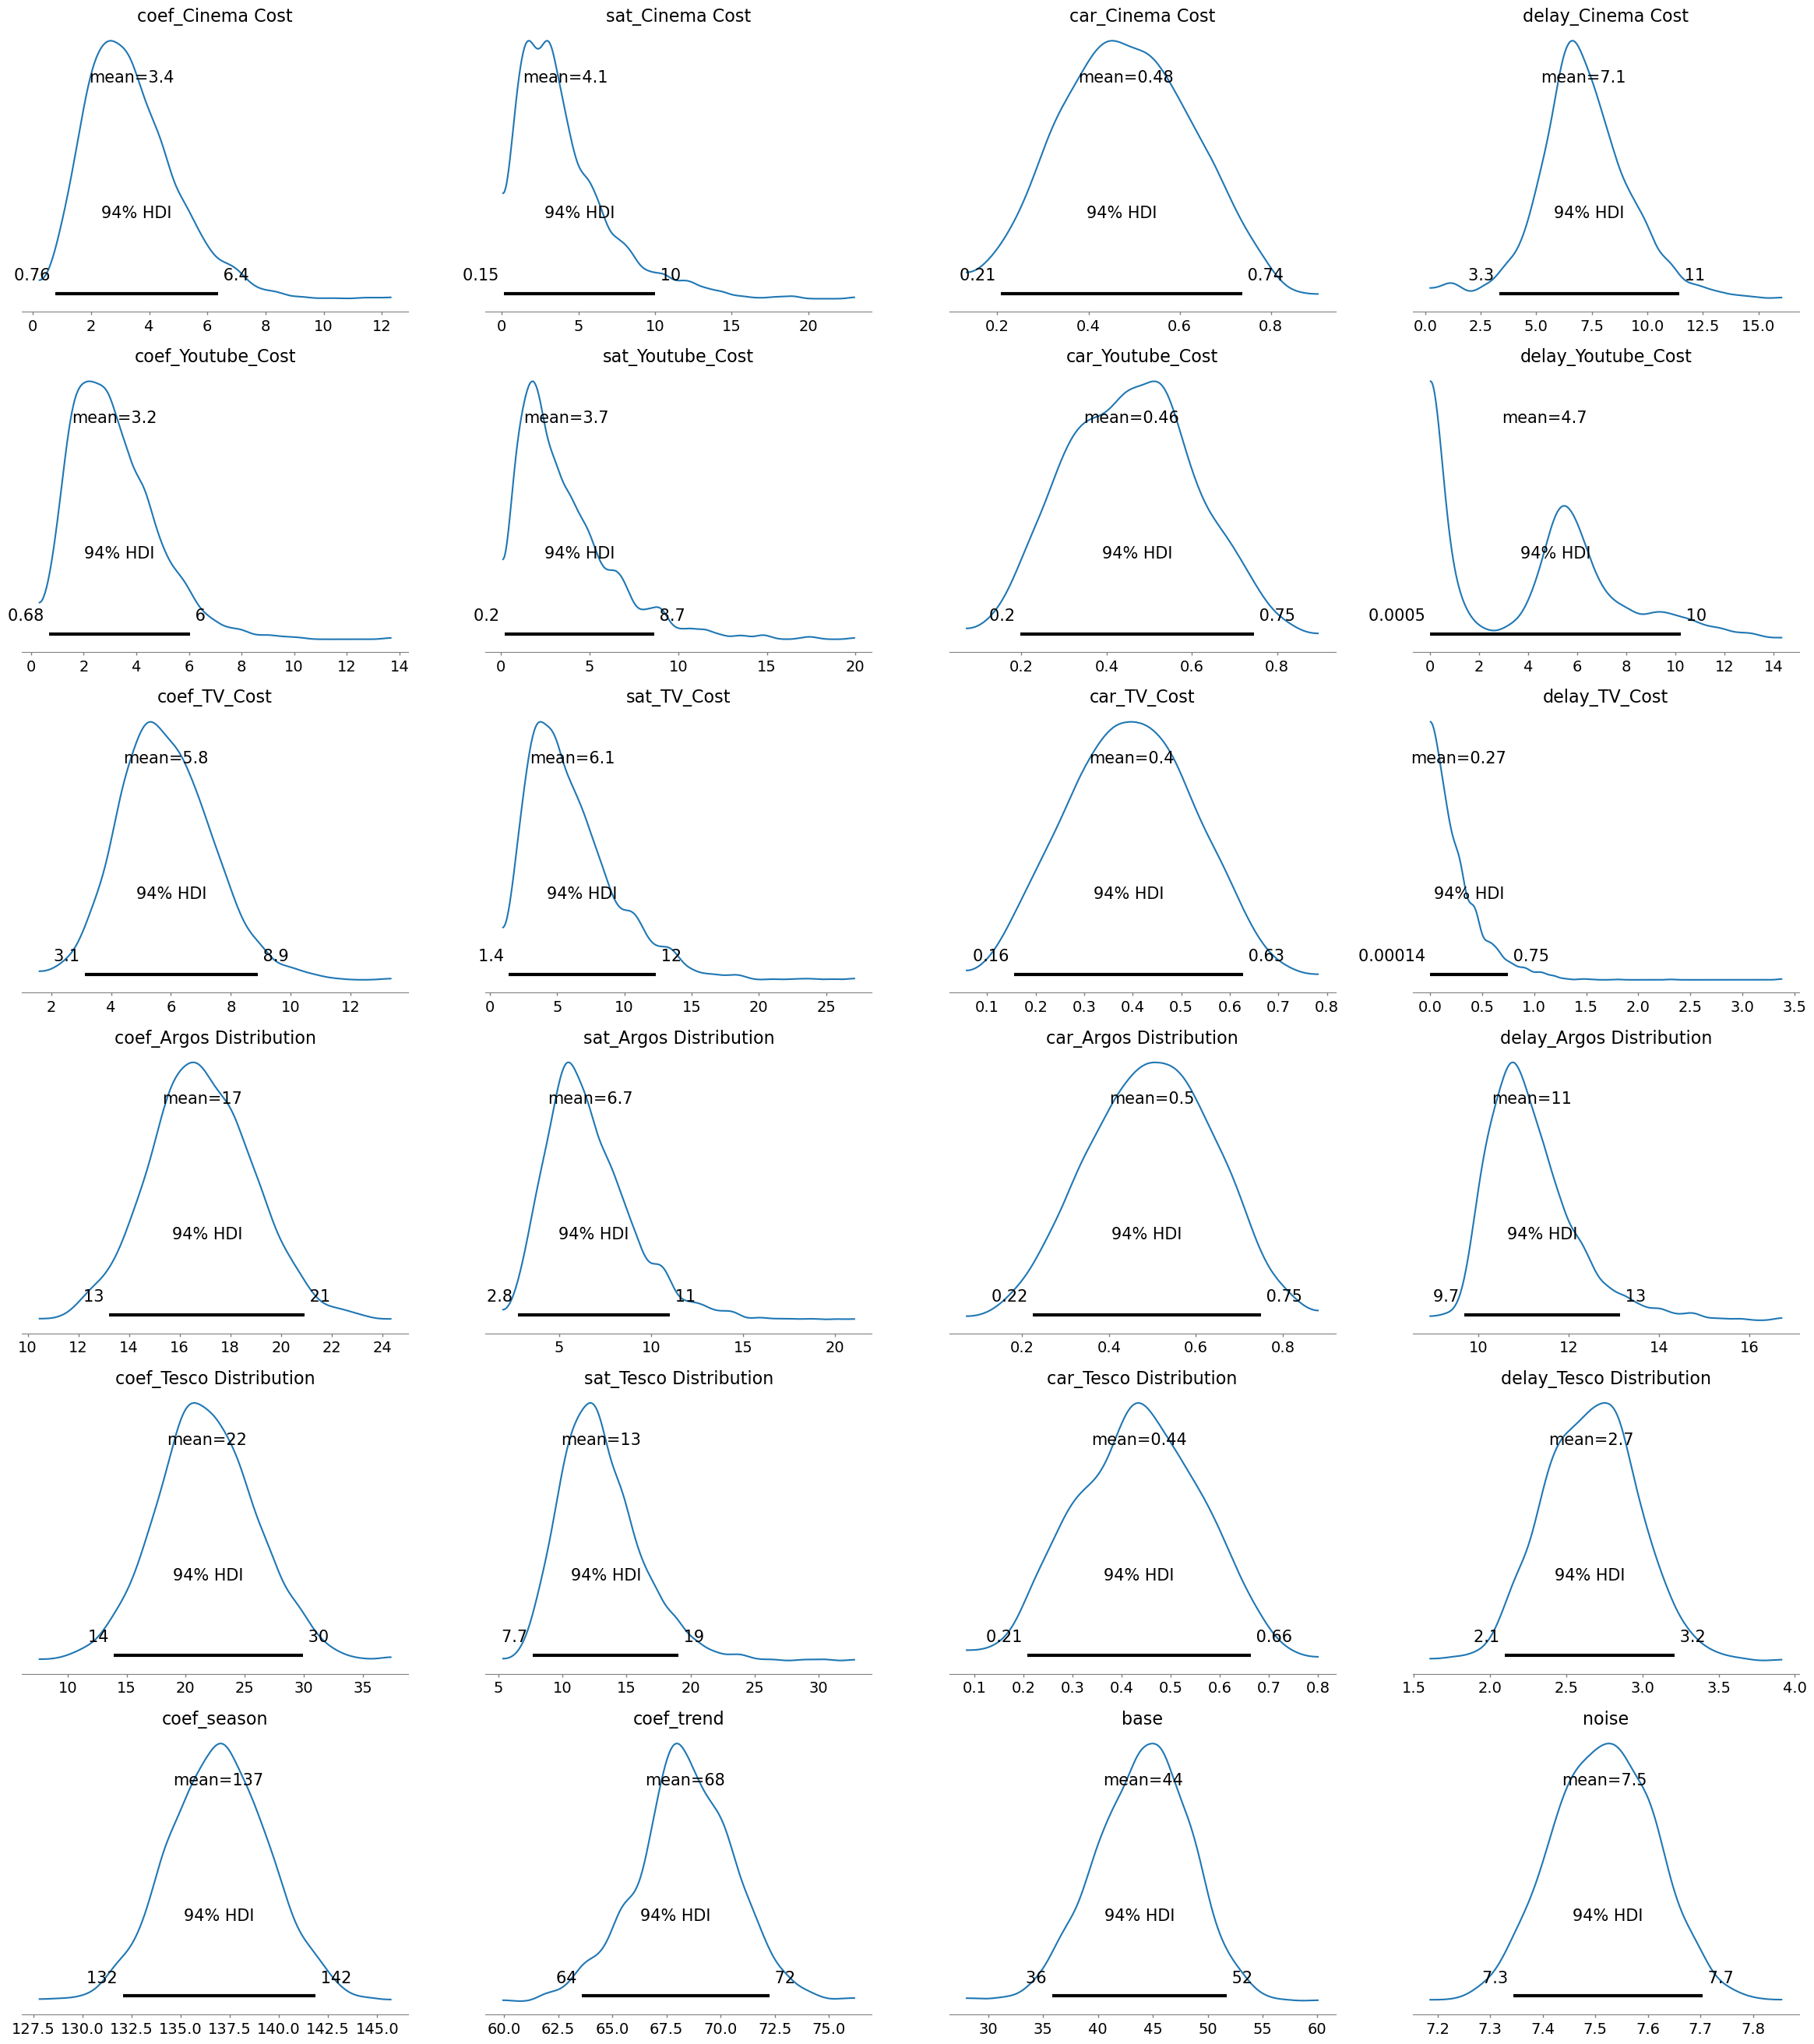

In [156]:
az.plot_posterior(
    trace,
    var_names=['~contribution'],
    filter_vars='like'
)

In [157]:
def draw_pred(trace_p, num):
    channel_contributions = []
    
    for channel in media_spend_columns:
        coef_values = trace_p.get(f'coef_{channel}').values
        sat_values = trace_p.get(f'sat_{channel}').values
        car_values = trace_p.get(f'car_{channel}').values
        delay_values = trace_p.get(f'delay_{channel}').values
        
        if coef_values.size == 4000:
            coef = coef_values.mean()
            sat = sat_values.mean()
            car = car_values.mean()
            delay = delay_values.mean()
            
            channel_data = X_transformed[channel].values
            channel_contribution = coef * saturate(
                carryover(
                    channel_data,
                    car,
                    delay
                ),
                sat
            ).eval()
            channel_contributions.append(channel_contribution)
        
        
    for channel in dist_columns:
        coef_values = trace_p.get(f'coef_{channel}').values
        sat_values = trace_p.get(f'sat_{channel}').values
        car_values = trace_p.get(f'car_{channel}').values
        delay_values = trace_p.get(f'delay_{channel}').values
        
        if coef_values.size == 4000:
            coef = coef_values.mean()
            sat = sat_values.mean()
            car = car_values.mean()
            delay = delay_values.mean()
            
            channel_data = X_transformed[channel].values
            channel_contribution = coef * saturate(
                carryover(
                    channel_data,
                    car,
                    delay
                ),
                sat
            ).eval()
            channel_contributions.append(channel_contribution)
        
    for channel in ['season', 'trend']:
        coef_values = trace_p.get(f'coef_{channel}').values
        if coef_values.size == 4000:
            coef = coef_values.mean()
            channel_data = X_transformed[channel].values
            channel_contribution = coef * channel_data
            channel_contributions.append(channel_contribution)
        
        
    base = 0.0  # Set a default value for base
    noise = 0.0  # Set a default value for noise
    
    base_values = trace_p.get('base').values
    noise_values = trace_p.get('noise').values
    
    if base_values.size == 4000:
        base = base_values.mean()
        noise = noise_values.mean()
    
    return np.sum(channel_contributions, axis=0) + base, noise


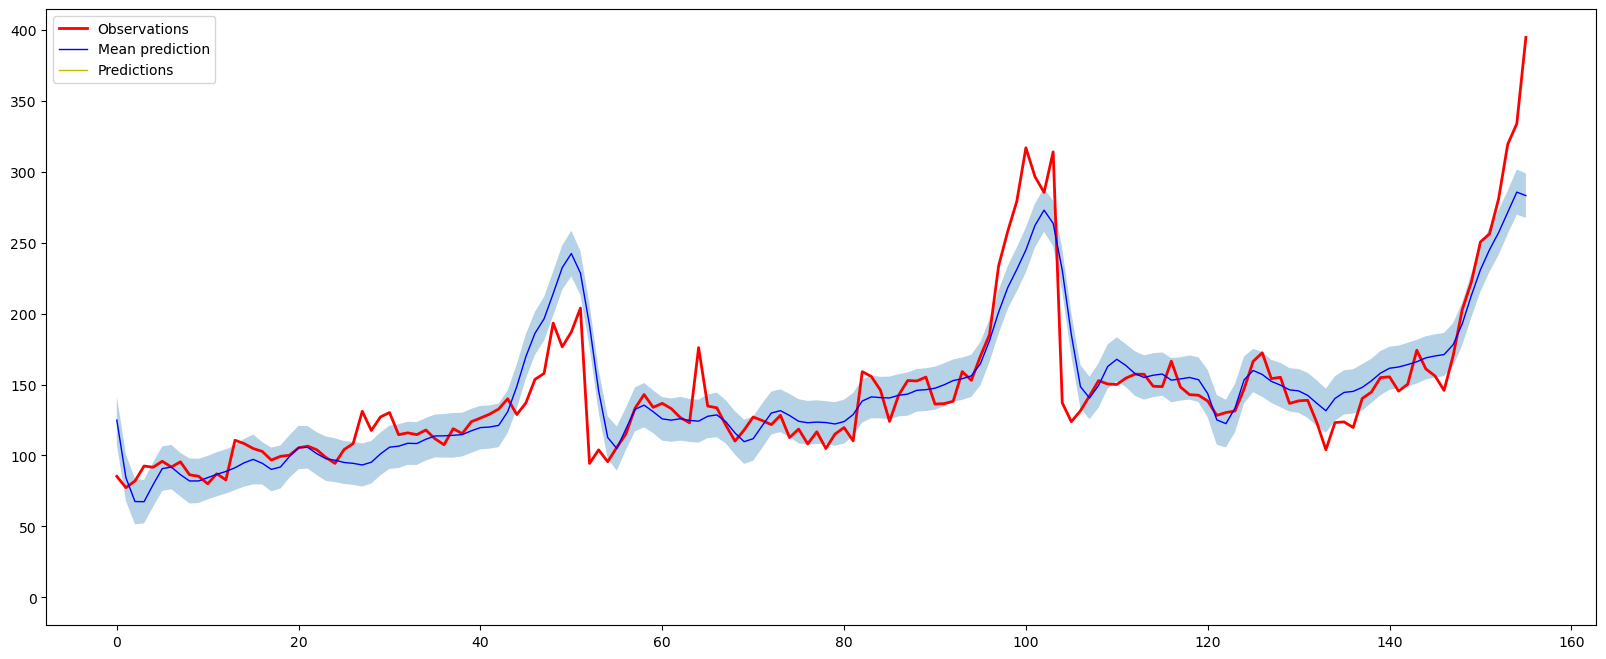

In [158]:
y_pred, y_noise = draw_pred(trace.posterior, 0)
means = posterior['sales'].mean(0)
stds = posterior['sales'].std(0)
plt.figure(figsize=(20, 8))
plt.plot(y_transformed, linewidth=2, c='r', label='Observations')
plt.plot(means, linewidth=1, c='b', label='Mean prediction')
plt.plot(y_pred, linewidth=1, c='y', label='Predictions')
plt.fill_between(np.arange(len(y)), means - 2*stds, means + 2*stds, alpha=0.33)
plt.fill_between(np.arange(len(y)), y_pred - y_noise, y_pred + y_noise, alpha=0.33)
plt.legend()

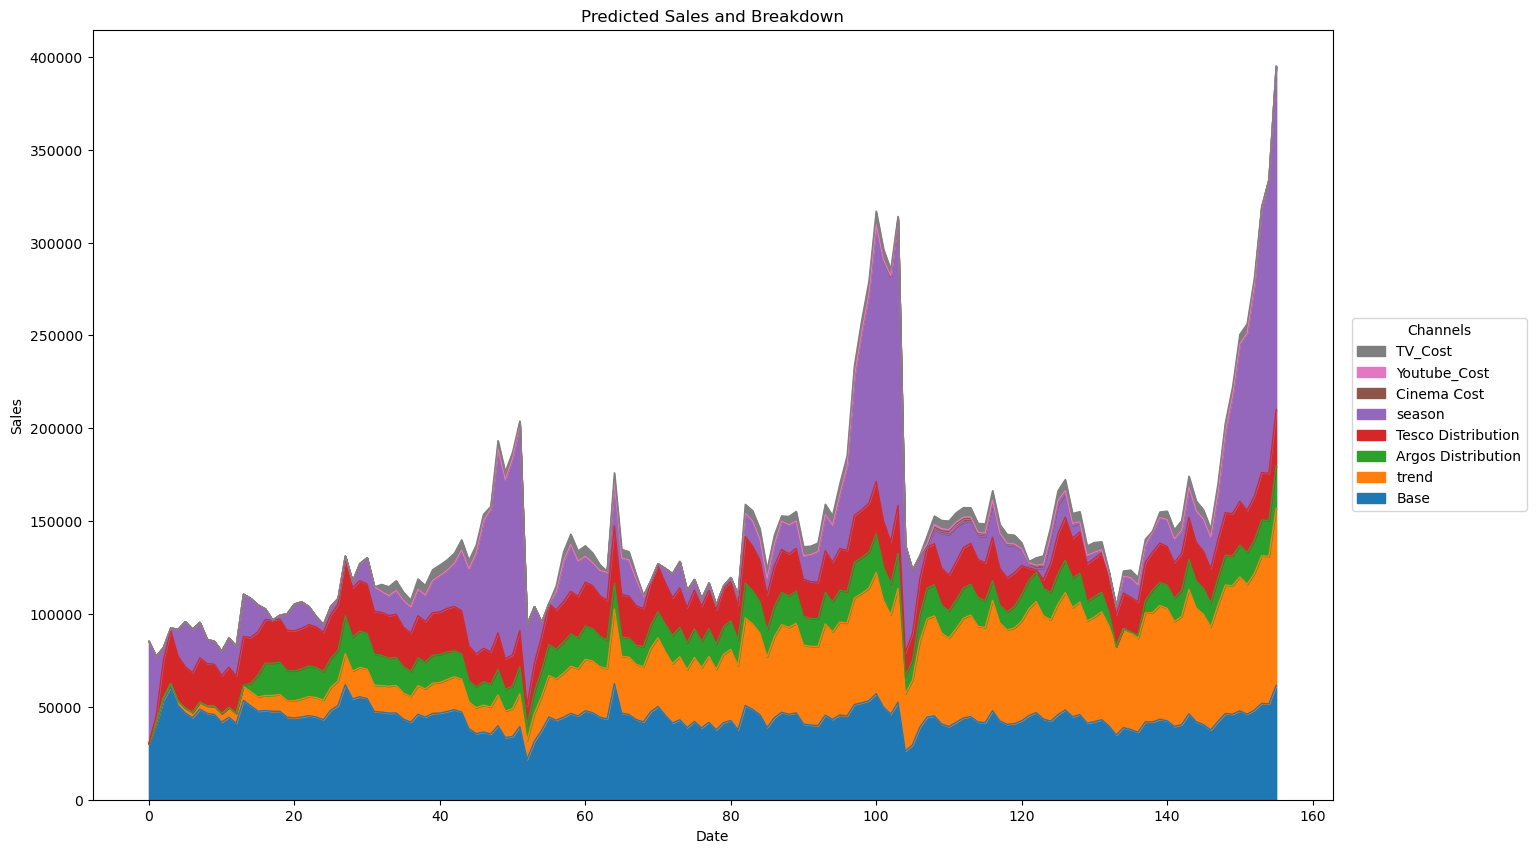

In [159]:
def compute_mean(trace, channel):
    return (trace
            .posterior[f'contribution_{channel}']
            .values
            .reshape(2000, -1)
            .mean(axis=0)
           )

channels = ['trend'] + dist_columns + ['season'] + media_spend_columns
unadj_contributions = pd.DataFrame(
   {'Base': trace.posterior['base'].values.mean()},
   index=X.index
)

for channel in channels:
    unadj_contributions[channel] = compute_mean(trace, channel)

adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

ax = (adj_contributions
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date'
      )
     )

handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)


In [160]:
def easy_saturate(x, a):
    return 1 - np.exp(-a*x)

def plot_hill(alpha, name):
    plt.figure(figsize=(30,10)) # Задаем размер графика
    x = np.linspace(0,1,1000)
    y = easy_saturate(x, alpha)
    plt.plot(x, y, label = f'SAT = {alpha}')
    plt.title(f'Saturation {name}', fontsize=30)
    plt.legend()
    
def plot_channel_saturation(channel):
    with mmm:
        plot_hill(trace.posterior[f'sat_{channel}'].values.reshape(2000, 1).mean(), channel)
    


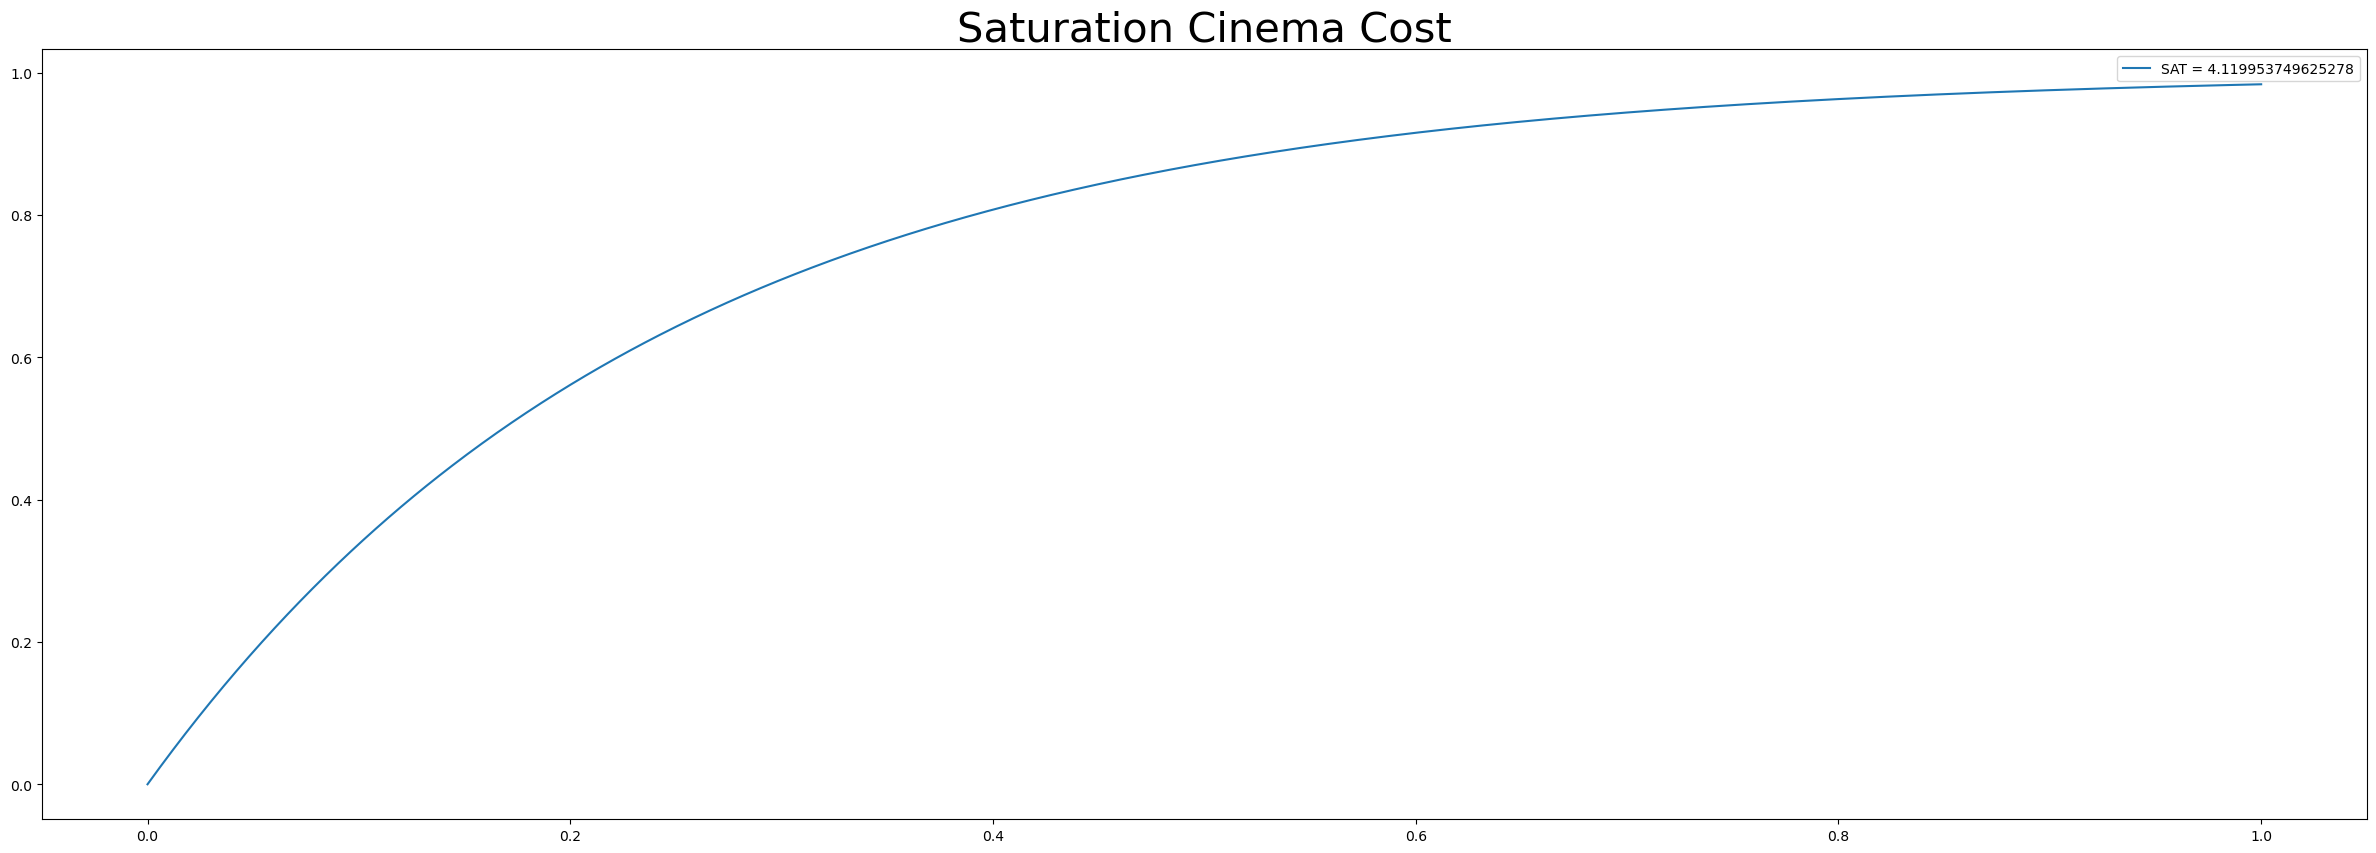

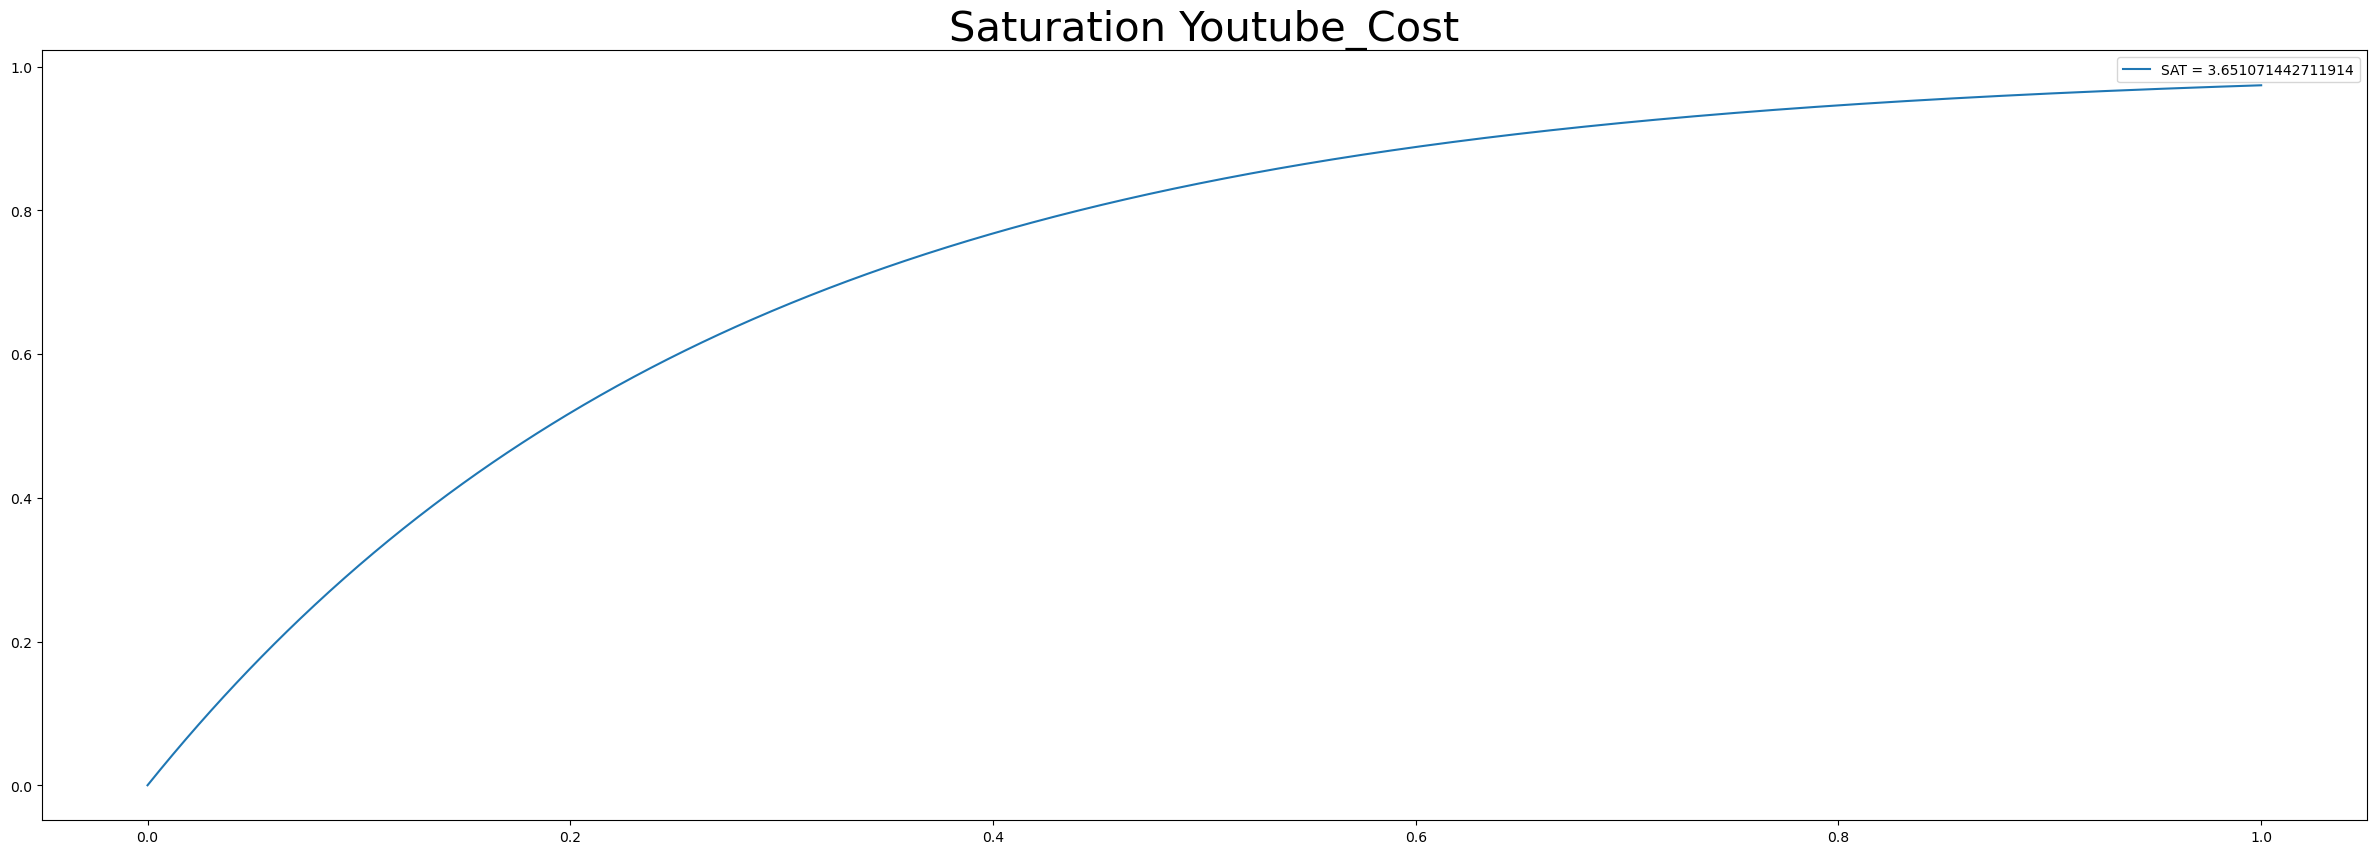

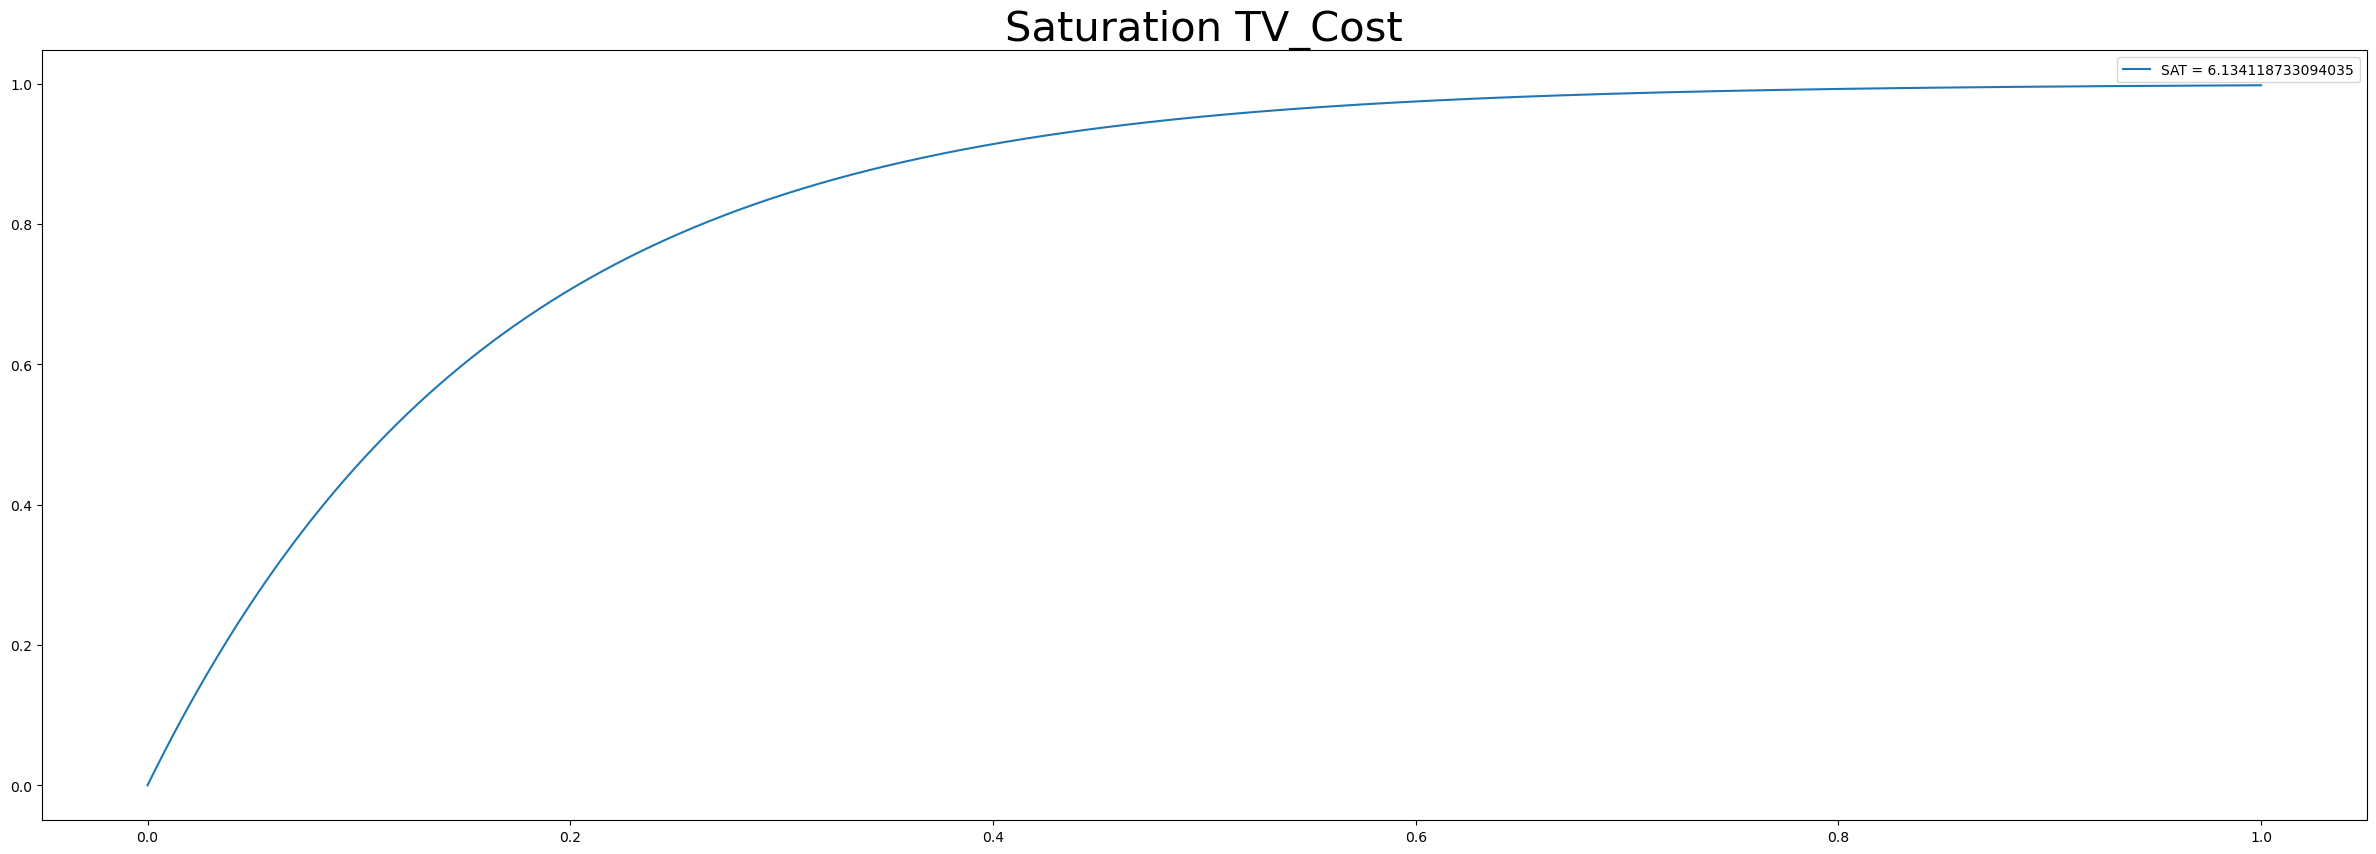

In [161]:
for channel in media_spend_columns:
    plot_channel_saturation(channel)

In [162]:
data.head()

,year,ds,Argos Sales Volume,Tesco Sales Volume,Argos Sales Value,Tesco Sales Value,Argos Price,Tesco Price,Argos Distribution,Tesco Distribution,Average UK Temperature,Average UK Rainfall,TVRs,Cinema Admissions,YouTube Impressions,y,TV_Cost,Youtube_Cost,Cinema Cost,trend,season
0,2015,2015-12-28,11795,10813,45056.90,40224.36,3.82,3.72,0.65,0.82,6.703522,8.932500,0,0.0,0,85281.26,0,0.0,0.0,109598.264636,62684.569717
1,2016,2016-01-04,9919,10482,38088.96,39202.68,3.84,3.74,0.65,0.82,6.492818,5.324286,0,0.0,0,77291.64,0,0.0,0.0,110105.015802,8883.407796
2,2016,2016-01-11,9276,10739,41927.52,40056.47,4.52,3.73,0.65,0.82,6.002794,6.311429,0,0.0,0,81983.99,0,0.0,0.0,110611.766969,-25977.987180
3,2016,2016-01-18,9585,13063,46678.95,45851.13,4.87,3.51,0.65,0.82,5.384591,4.302857,0,0.0,0,92530.08,0,0.0,0.0,111118.518136,-31197.360330
4,2016,2016-01-25,8378,15554,41135.98,50550.50,4.91,3.25,0.65,0.82,5.000951,6.515714,0,0.0,0,91686.48,0,0.0,0.0,111625.269302,-17766.668164


In [163]:
def plot_channel(channel):
    sat = trace.posterior[f'sat_{channel}'].values.reshape(2000, 1).mean()
    delay = trace.posterior[f'delay_{channel}'].values.reshape(2000, 1).mean()
    car = trace.posterior[f'car_{channel}'].values.reshape(2000, 1).mean()
    plt.figure(figsize=(30,10))
    plt.plot(data['ds'], X_transformed[channel], label='Cost')
    plt.plot(data['ds'], saturate(carryover(tt.as_tensor_variable(X_transformed[channel]), car, delay), sat).eval(), label='Channel effect')
    plt.legend()
    plt.title(f'Adstock and saturation {channel} (lag ~ {round(delay)}w)', fontsize=30)
    plt.show()

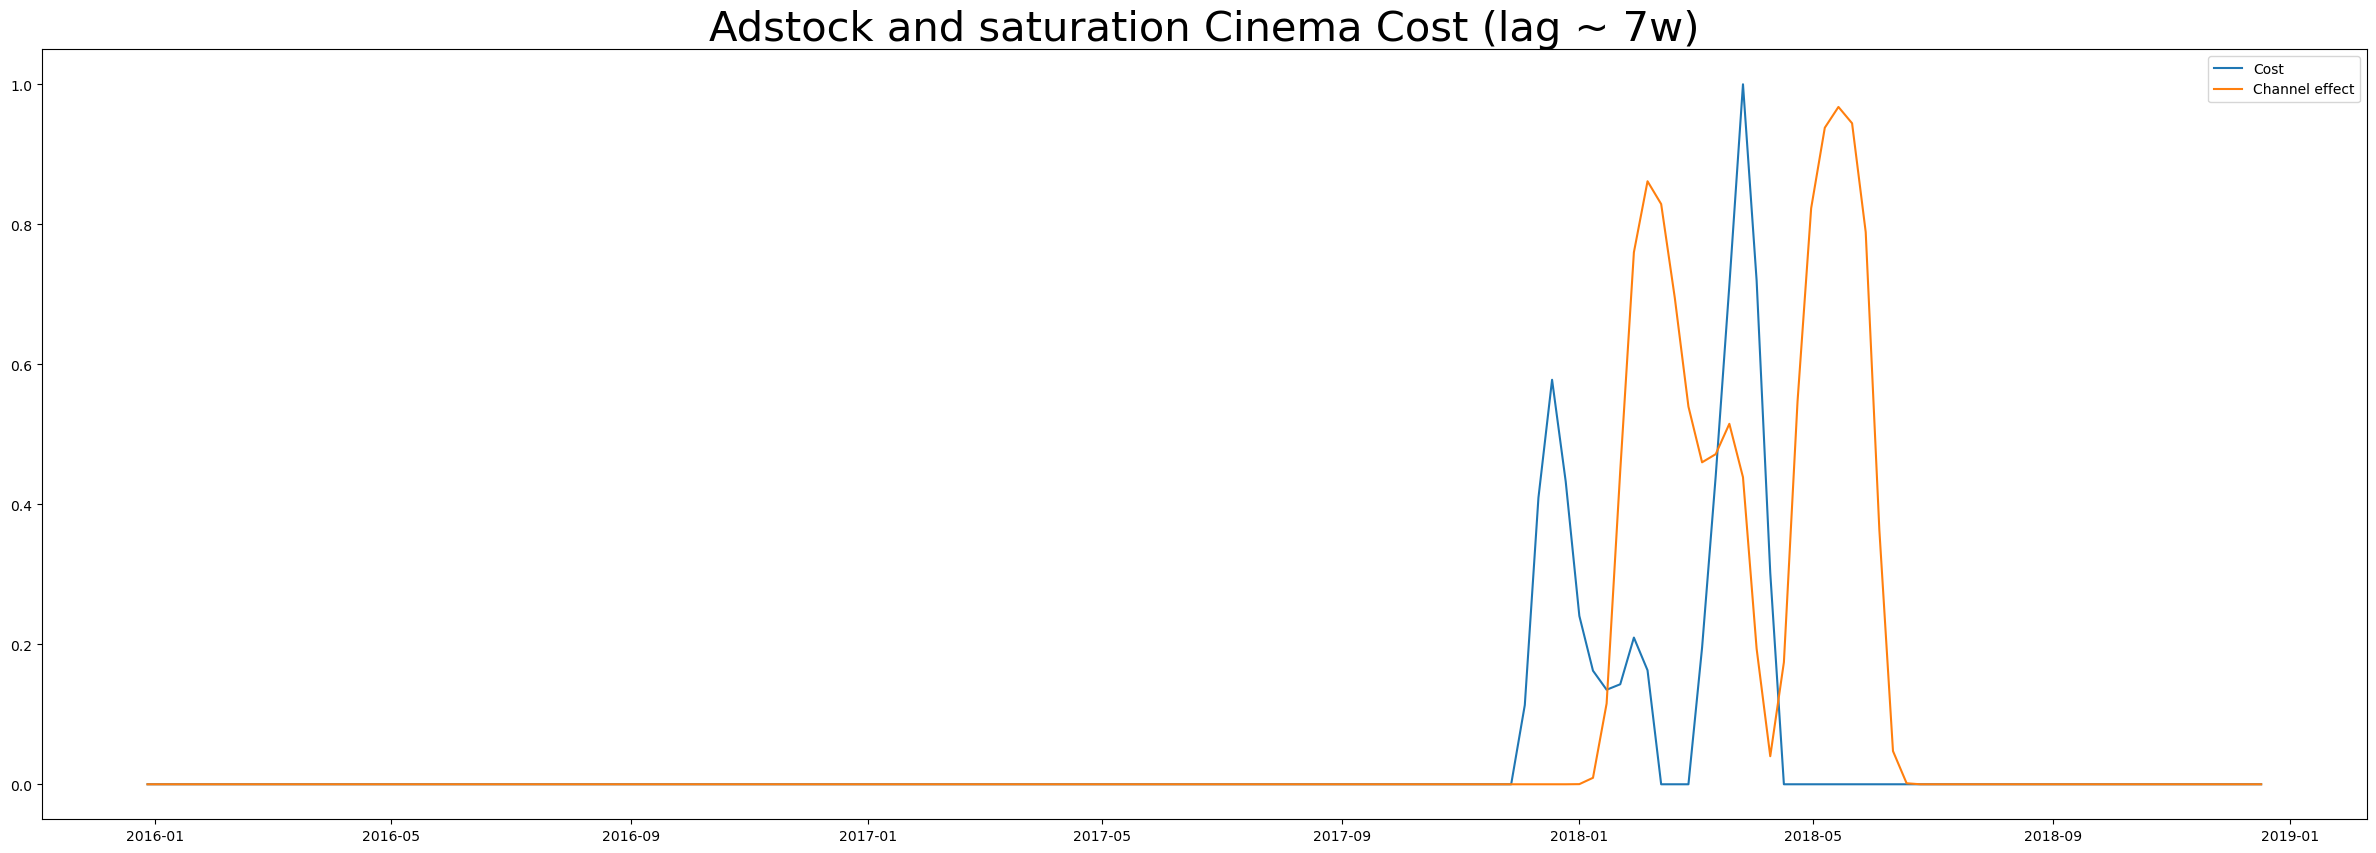

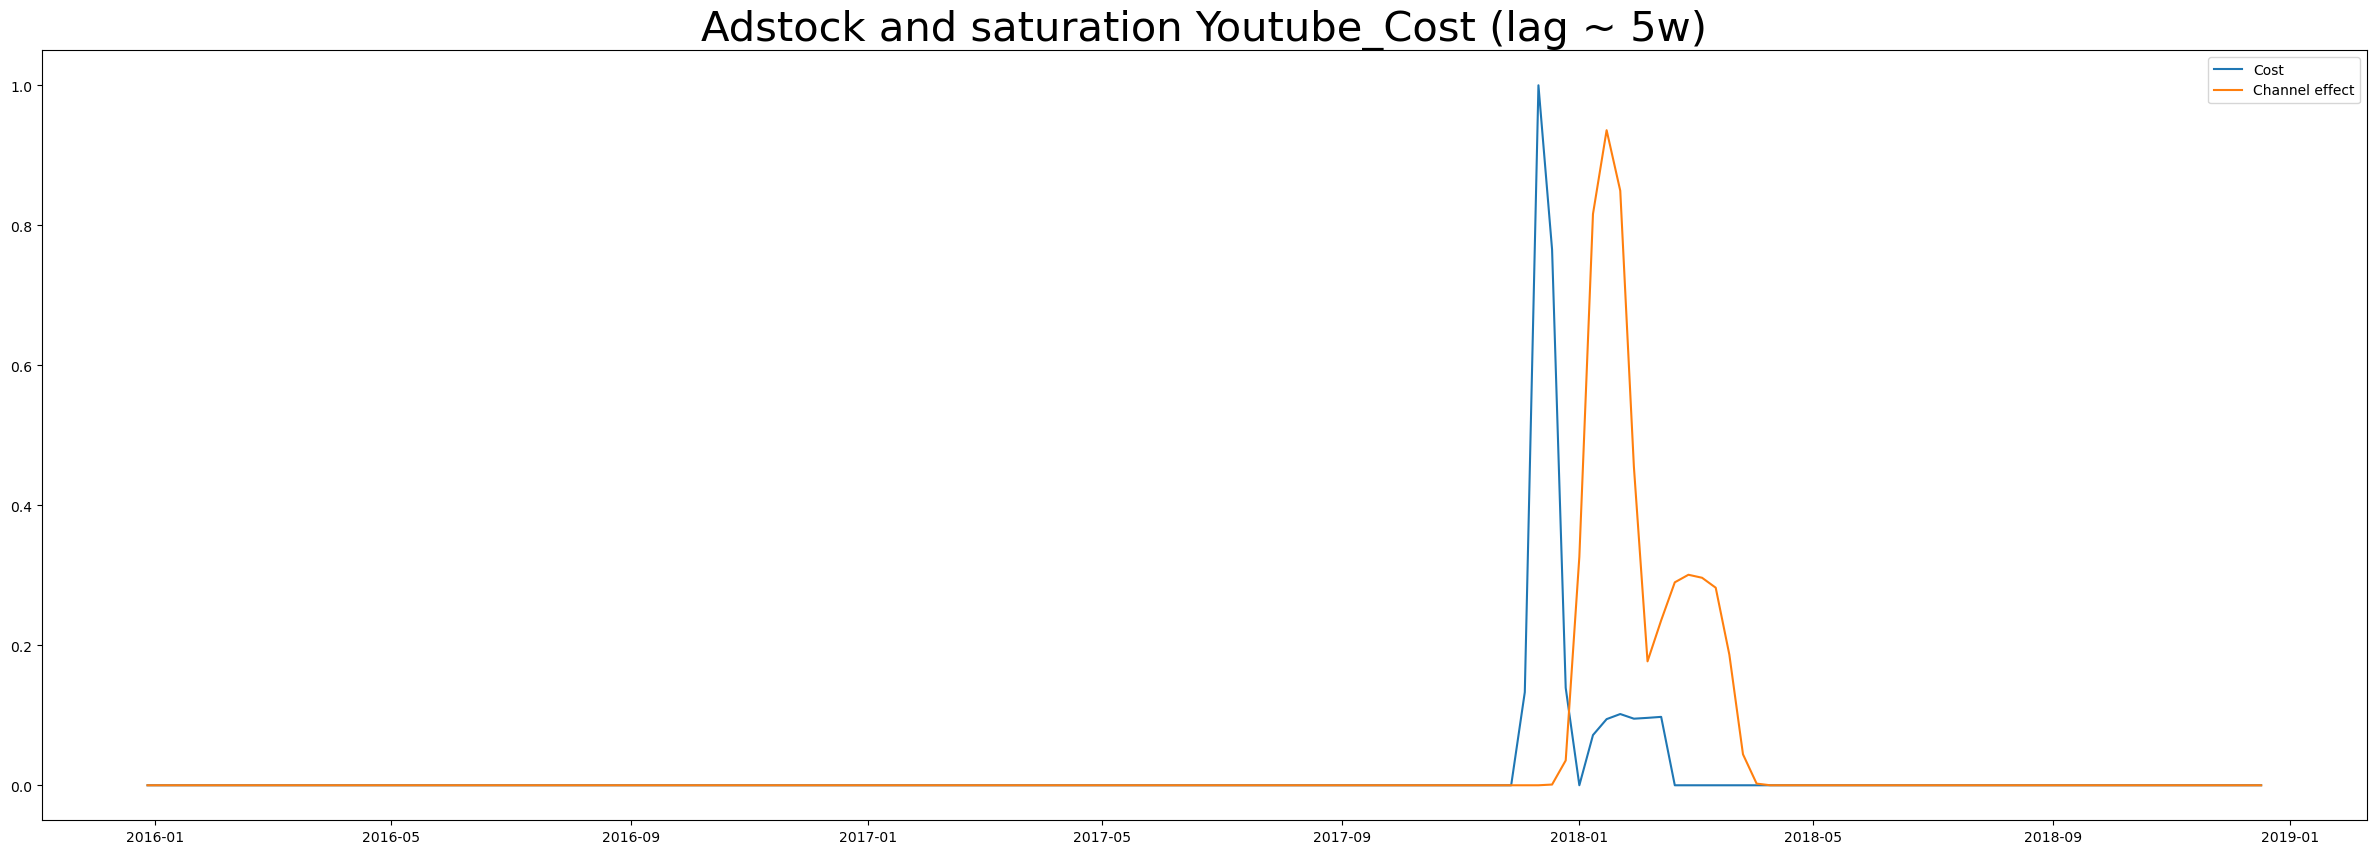

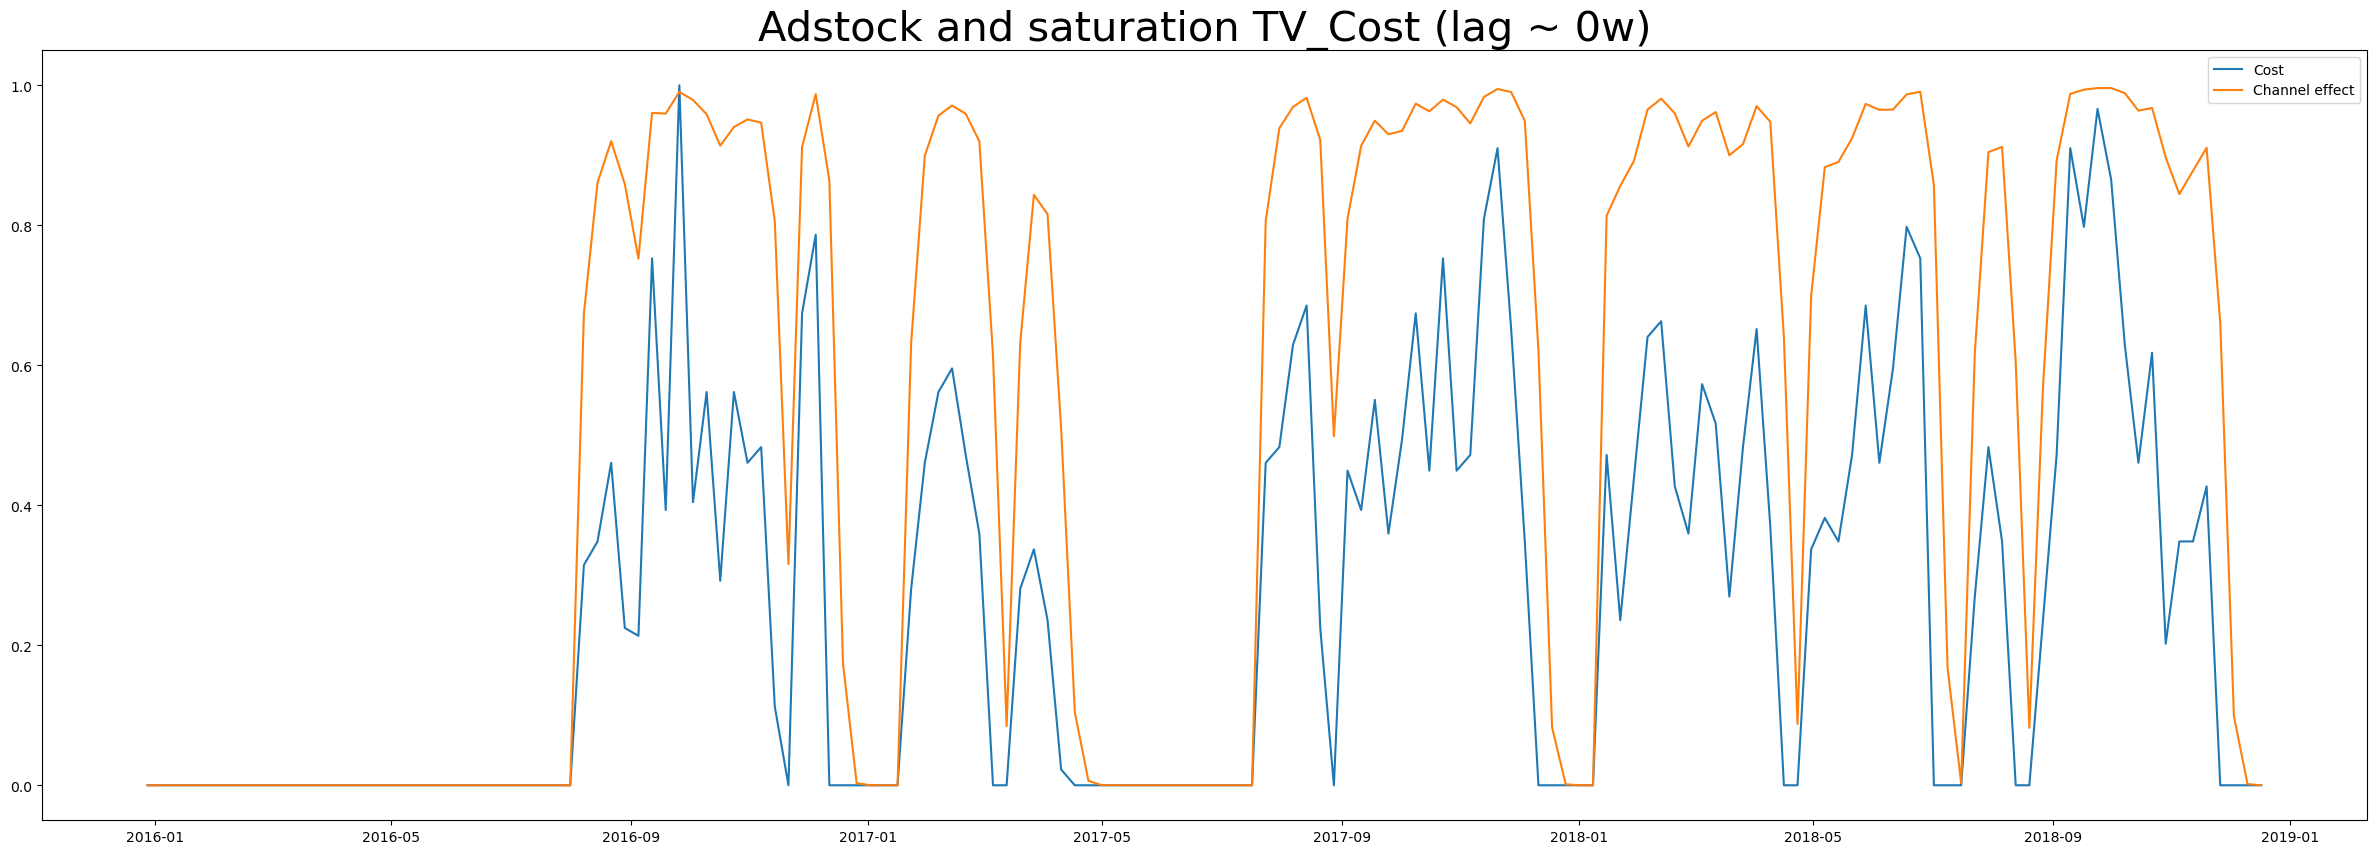

In [164]:
for channel in media_spend_columns:
    plot_channel(channel)

In [165]:
def calc_prop(channel):
    sat = trace.posterior[f'sat_{channel}'].values.reshape(2000, 1).mean()
    delay = trace.posterior[f'delay_{channel}'].values.reshape(2000, 1).mean()
    car = trace.posterior[f'car_{channel}'].values.reshape(2000, 1).mean()
    
    ch_effect = saturate(carryover(tt.as_tensor_variable(X_transformed[channel]), car, delay), sat).eval()
    cost = X_transformed[channel]
    
    return {    
        "abs_effect": ch_effect.sum() - cost.sum(),
        "ROAS": ch_effect.sum() / cost.sum() * 100
    }

money_eff = {ch: calc_prop(ch) for ch in media_spend_columns}

<BarContainer object of 3 artists>

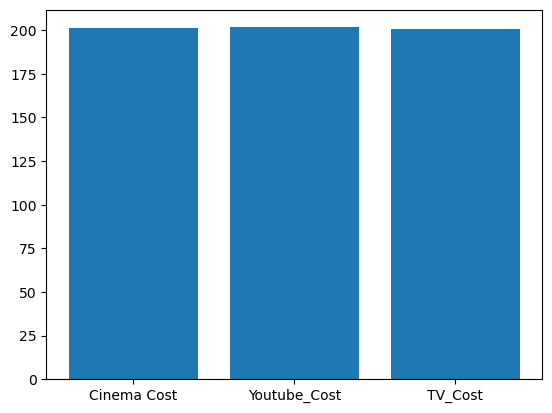

In [166]:
bar(media_spend_columns, [money_eff[k]["ROAS"] for k in media_spend_columns])

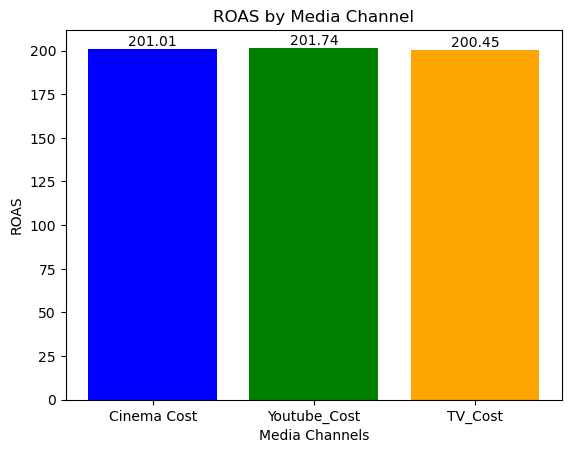

In [168]:
import numpy as np
import matplotlib.pyplot as plt


roas_values = [money_eff[k]['ROAS'] for k in media_spend_columns]
colors = ['blue', 'green', 'orange']

fig, ax = plt.subplots()
bars = ax.bar(media_spend_columns, roas_values, color=colors)

plt.title('ROAS by Media Channel')
plt.xlabel('Media Channels')
plt.ylabel('ROAS')

# Add numbers on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

plt.show()


In [169]:
all_channel_spend = data[media_spend_columns].sum(axis=0)
spend_share = pd.DataFrame(all_channel_spend / all_channel_spend.sum() * 100, columns=['spend'])
spend_share

,spend
Cinema Cost,6.380184
Youtube_Cost,0.083505
TV_Cost,93.536311


In [170]:
all_channel_effect = adj_contributions.sum(axis=0)
effect_share = pd.DataFrame(all_channel_effect / all_channel_effect.sum() * 100, columns=['effect'])
effect_share

,effect
Base,30.699431
trend,24.602495
Argos Distribution,9.159029
Tesco Distribution,14.619935
season,18.737502
Cinema Cost,0.148982
Youtube_Cost,0.057884
TV_Cost,1.974742


<AxesSubplot:>

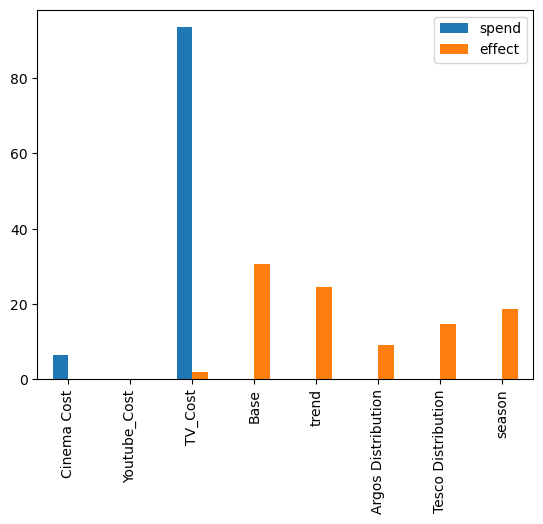

In [171]:
spend_effect = pd.concat([spend_share, effect_share], axis=1)
spend_effect.plot.bar()